In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


**Задание light:**

Для базы Fashion-Mnist:
1. Построить CVAE c помощью глубоких полносвязных (сверточных) нейронных сетей. Добиться хорошего качества генерации изображений. Использовать различные архитектуры энкодера и декодера (количество слоев, фильтров в слоях, размеры ядер, слоев нормализации) для различных наборов гипермапараметров (оптимизатор, размер мини-выборки, количество эпох и т.д.). 
2. Ответить на вопрос: как зависит качество генерируемых изображений от размерности скрытого пространства?
 
**Задание pro:**

Для базы Cats&Dogs (или Cifar-10):
1. Выполните задание light для сверточных нейронных сетей.
2. Ответить на вопрос: как зависит качество генерируемых изображений от размерности скрытого пространства? Привести примеры.


In [0]:
!mkdir ~/.kaggle
!cp /content/drive/My\ Drive/kaggle.json ~/.kaggle
!ls ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists
kaggle.json


#Mnist

In [0]:
import sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import norm
# import seaborn as sns

from keras.datasets import mnist
from keras.utils import to_categorical
(x_train, y_train), (x_test, y_test) = mnist.load_data()
#(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test  = x_test .astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test  = np.reshape(x_test,  (len(x_test),  28, 28, 1))

y_train_cat = to_categorical(y_train).astype(np.float32)
y_test_cat  = to_categorical(y_test).astype(np.float32)
num_classes = y_test_cat.shape[1]

Using TensorFlow backend.


11493376/11490434 [==============================] - 0s 0us/step


##cvae model

In [0]:
from keras.layers import Input, Dense 
from keras.layers import BatchNormalization, Dropout, Flatten, Reshape, Lambda, LeakyReLU
from keras.layers import concatenate
from keras import Model
from keras.losses import binary_crossentropy
#from tensorflow.keras.layers.advanced_activations import LeakyReLU
from keras import backend as K

num_classes = 10
def create_cvae():
    models = {}

    # Добавим Dropout и BatchNormalization
    def apply_bn_and_dropout(x):
        return Dropout(dropout_rate)(BatchNormalization()(x))

    # Энкодер
    input_img = Input(shape=(28, 28, 1))
    flatten_img = Flatten()(input_img)
    input_lbl = Input(shape=(num_classes,), dtype='float32')

    x = concatenate([flatten_img, input_lbl])
    
    x = Dense(256, activation='relu')(x)
    
    x = apply_bn_and_dropout(x)
    
    # Предсказываем параметры распределений
    
    # Вместо того чтобы предсказывать стандартное отклонение, предсказываем логарифм вариации
    z_mean = Dense(latent_dim)(x)
    z_log_var = Dense(latent_dim)(x)

    # Сэмплирование из Q с трюком репараметризации
    def sampling(args):
        z_mean, z_log_var = args
        epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0., stddev=1.0)
        return z_mean + K.exp(z_log_var / 2) * epsilon
    l = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

    models["encoder"]  = Model([input_img, input_lbl], l, name='Encoder') 
    models["z_meaner"] = Model([input_img, input_lbl], z_mean, name='Enc_z_mean')
    models["z_lvarer"] = Model([input_img, input_lbl], z_log_var, name='Enc_z_log_var')

    # Декодер
    z = Input(shape=(latent_dim, ))
    
    input_lbl_d = Input(shape=(num_classes,), dtype='float32')
    x = concatenate([z, input_lbl_d])
    x = Dense(256)(x)
    x = LeakyReLU()(x)
    x = apply_bn_and_dropout(x)
    x = Dense(28*28, activation='sigmoid')(x)
    decoded = Reshape((28, 28, 1))(x)

    models["decoder"] = Model([z, input_lbl_d], decoded, name='Decoder')
    
    
    models["cvae"]    = Model([input_img, input_lbl, input_lbl_d],                               
                             models["decoder"]([models["encoder"]([input_img, input_lbl]), input_lbl_d]), name="CVAE")
    
    models["style_t"] = Model( [input_img, input_lbl, input_lbl_d] , 
                             models["decoder"] ( [models["z_meaner"]([input_img, input_lbl]), input_lbl_d] ) , name="style_transfer")
    
    
    def vae_loss(x, decoded):
        x = K.reshape(x, shape=(batch_size, 28*28))
        decoded = K.reshape(decoded, shape=(batch_size, 28*28))
        xent_loss = 28*28*binary_crossentropy(x, decoded)
        kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return (xent_loss + kl_loss)/2/28/28

    return models, vae_loss



In [0]:
save_epochs

In [0]:
batch_size = 500
latent_dim = 8 #!!!!!
dropout_rate = 0.3
start_lr = 0.001

num_classes = 10
start_filters = 16

start_lr = 1e-3

models, vae_loss = create_cvae()
cvae = models["cvae"]

from keras.optimizers import Adam, RMSprop
cvae.compile(optimizer=Adam(start_lr), loss=vae_loss)

In [0]:
digit_size = 28
def plot_digits(*args, invert_colors=False):
    args = [x.squeeze() for x in args]
    n = min([x.shape[0] for x in args])
    figure = np.zeros((digit_size * len(args), digit_size * n))

    for i in range(n):
        for j in range(len(args)):
            figure[j * digit_size: (j + 1) * digit_size,
                   i * digit_size: (i + 1) * digit_size] = args[j][i].squeeze()

    if invert_colors:
        figure = 1-figure

    plt.figure(figsize=(2*n, 2*len(args)))
    plt.imshow(figure, cmap='Greys_r')
    plt.grid(False)
    ax = plt.gca()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.show()


n = 15 # Картинка с 15x15 цифр

from IPython.display import clear_output
from keras.callbacks import LambdaCallback, ReduceLROnPlateau, TensorBoard

# Эпохи, в которые будем сохранять
save_epochs = set([i*5 for i in range(0,25)])

# Отслеживать будем на вот этих цифрах
imgs = x_test[:batch_size]
imgs_lbls = y_test_cat[:batch_size]
n_compare = 10

# Модели
generator      = models["decoder"]
encoder_mean   = models["z_meaner"]


# Функция, которую будем запускать после каждой эпохи
def on_epoch_end(epoch, logs):
    if epoch in save_epochs:
        clear_output() # Не захламляем output

        # Сравнение реальных и декодированных цифр
        decoded = cvae.predict([imgs, imgs_lbls, imgs_lbls], batch_size=batch_size)
        plot_digits(imgs[:n_compare], decoded[:n_compare])



# Коллбэки
pltfig = LambdaCallback(on_epoch_end=on_epoch_end)
# lr_red = ReduceLROnPlateau(factor=0.1, patience=25)
#tb     = TensorBoard(log_dir='./logs')




###latent_dim = 2

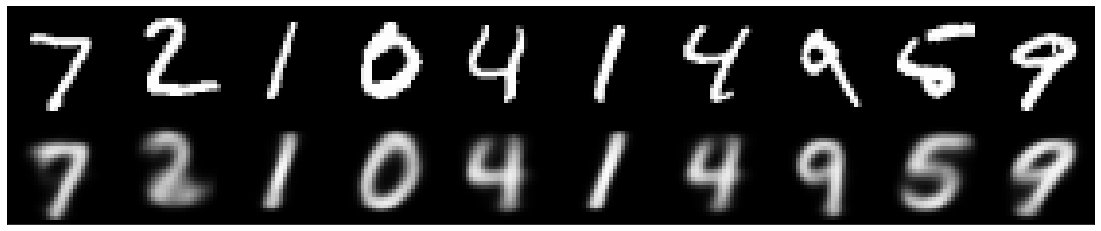

0.09397328458726406


In [0]:
latent_dim = 2 #!!!!!

models, vae_loss = create_cvae()
cvae = models["cvae"]

from keras.optimizers import Adam, RMSprop
cvae.compile(optimizer=Adam(start_lr), loss=vae_loss)

history = cvae.fit([x_train, y_train_cat, y_train_cat], x_train, shuffle=True, epochs=11,
         batch_size=batch_size,
         validation_data=([x_test, y_test_cat, y_test_cat], x_test),
         callbacks=[pltfig],
         verbose=1)

print(np.min(history.history['loss']))

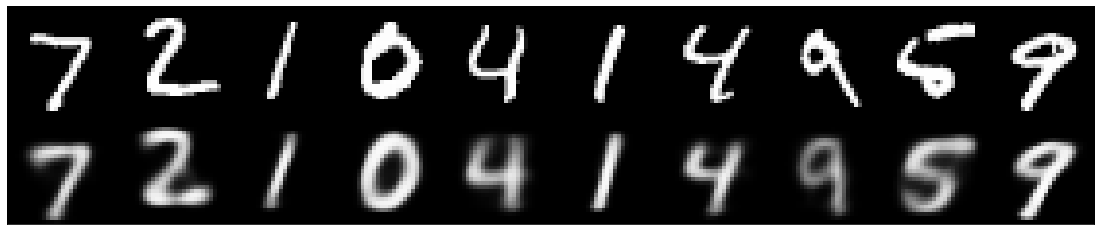

0.08877548271169265


In [0]:
latent_dim = 4 #!!!!!

models, vae_loss = create_cvae()
cvae = models["cvae"]

from keras.optimizers import Adam, RMSprop
cvae.compile(optimizer=Adam(start_lr), loss=vae_loss)

history = cvae.fit([x_train, y_train_cat, y_train_cat], x_train, shuffle=True, epochs=11,
         batch_size=batch_size,
         validation_data=([x_test, y_test_cat, y_test_cat], x_test),
         callbacks=[pltfig],
         verbose=1)

print(np.min(history.history['loss']))

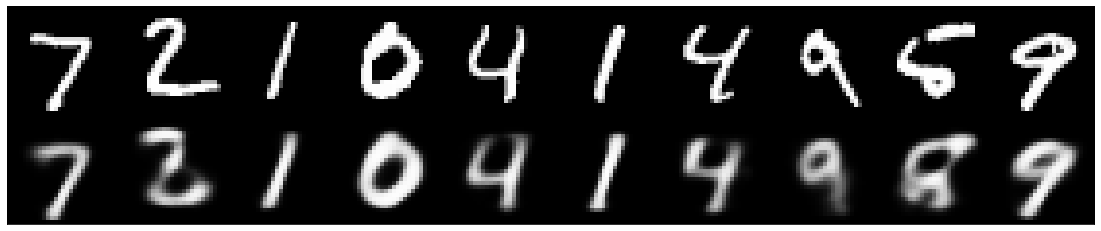

0.08349495325237513


In [0]:
latent_dim = 8 #!!!!!
models, vae_loss = create_cvae()
cvae = models["cvae"]

from keras.optimizers import Adam, RMSprop
cvae.compile(optimizer=Adam(start_lr), loss=vae_loss)

history = cvae.fit([x_train, y_train_cat, y_train_cat], x_train, shuffle=True, epochs=11,
         batch_size=batch_size,
         validation_data=([x_test, y_test_cat, y_test_cat], x_test),
         callbacks=[pltfig],
         verbose=1)

print(np.min(history.history['loss']))

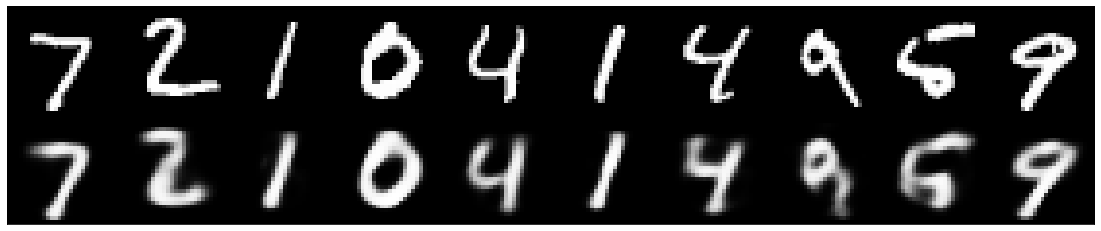

0.07982148776451746


In [0]:
latent_dim = 16 #!!!!!

models, vae_loss = create_cvae()
cvae = models["cvae"]

from keras.optimizers import Adam, RMSprop
cvae.compile(optimizer=Adam(start_lr), loss=vae_loss)

history = cvae.fit([x_train, y_train_cat, y_train_cat], x_train, shuffle=True, epochs=11,
         batch_size=batch_size,
         validation_data=([x_test, y_test_cat, y_test_cat], x_test),
         callbacks=[pltfig],
         verbose=1)

print(np.min(history.history['loss']))

###latent_dim = 24

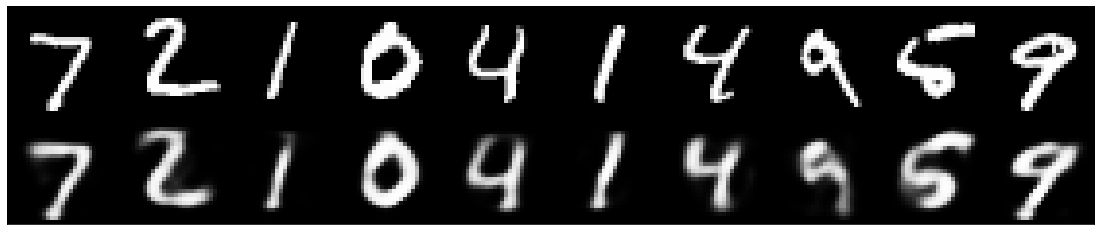

0.0794723043218255


In [0]:
latent_dim = 24 #!!!!!

models, vae_loss = create_cvae()
cvae = models["cvae"]

from keras.optimizers import Adam, RMSprop
cvae.compile(optimizer=Adam(start_lr), loss=vae_loss)

history = cvae.fit([x_train, y_train_cat, y_train_cat], x_train, shuffle=True, epochs=11,
         batch_size=batch_size,
         validation_data=([x_test, y_test_cat, y_test_cat], x_test),
         callbacks=[pltfig],
         verbose=1)

print(np.min(history.history['loss']))

###latent_dim = 32

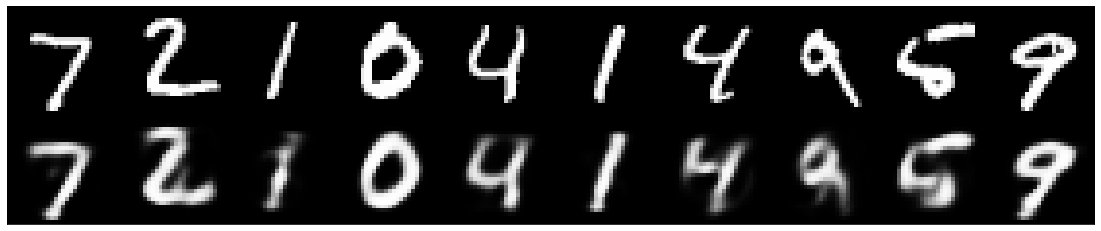

0.08014820752044519


In [0]:
latent_dim = 32 #!!!!!

models, vae_loss = create_cvae()
cvae = models["cvae"]

from keras.optimizers import Adam, RMSprop
cvae.compile(optimizer=Adam(start_lr), loss=vae_loss)

history = cvae.fit([x_train, y_train_cat, y_train_cat], x_train, shuffle=True, epochs=11,
         batch_size=batch_size,
         validation_data=([x_test, y_test_cat, y_test_cat], x_test),
         callbacks=[pltfig],
         verbose=1)

print(np.min(history.history['loss']))

###latent_dim = 256

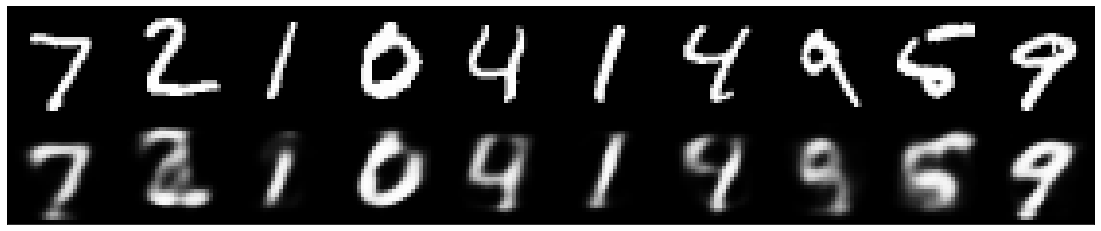

0.08640181993444761


In [0]:
latent_dim = 256 #!!!!!

models, vae_loss = create_cvae()
cvae = models["cvae"]

from keras.optimizers import Adam, RMSprop
cvae.compile(optimizer=Adam(start_lr), loss=vae_loss)

history = cvae.fit([x_train, y_train_cat, y_train_cat], x_train, shuffle=True, epochs=11,
         batch_size=batch_size,
         validation_data=([x_test, y_test_cat, y_test_cat], x_test),
         callbacks=[pltfig],
         verbose=1)

print(np.min(history.history['loss']))

#cats-and-dogs

##Load 

In [0]:
!kaggle competitions download -c nu-cats-and-dogs-spring2019
!unzip -q train.zip
!unzip -q test.zip

 90% 98.0M/108M [00:00<00:00, 97.8MB/s]
100% 108M/108M [00:00<00:00, 123MB/s]  
  0% 0.00/10.7k [00:00<?, ?B/s]
100% 10.7k/10.7k [00:00<00:00, 9.16MB/s]
 41% 9.00M/22.1M [00:00<00:00, 76.2MB/s]
100% 22.1M/22.1M [00:00<00:00, 108MB/s] 


##generator

In [0]:
import glob
import numpy as np


cats = glob.glob('train/cats/*.*')
dogs = glob.glob('train/dogs/*.*')
lbl_cats = np.repeat(0,len(cats)*2).reshape((len(cats),2))
lbl_cats[:,0] = 1
lbl_dogs = np.repeat(0,len(dogs)*2).reshape((len(dogs),2))
lbl_dogs[:,1] = 1

#меняем классы местами
# lbl_cats = np.repeat(0,len(cats)*2).reshape((len(cats),2))
# lbl_cats[:,0] = 1
# lbl_dogs = np.repeat(0,len(dogs)*2).reshape((len(dogs),2))
# lbl_dogs[:,1] = 1


fnames = np.vstack((cats,dogs)).flatten()
lbl = np.vstack((lbl_cats,lbl_dogs))

idx = np.random.randint(0,fnames.shape[0],fnames.shape[0])
fnames = fnames[idx]
lbl = lbl[idx]

from sklearn.model_selection import train_test_split

train_names, test_names, train_lbl, test_lbl = train_test_split(fnames, lbl, test_size=.1, random_state=13)


(4500, 2)

In [0]:
import os
import matplotlib.pyplot as plt
from PIL import Image
from imgaug import augmenters as iaa
img_width = 32
img_height = 32
batch_size = 64

img_path = '/content/drive/My Drive/data/'
def generator_train():  
  seq = iaa.Sequential([
      #nearest, linear, area or cubic
    iaa.Resize({"height": img_width, "width": img_height}, interpolation = 'area'),
  ])   
  
  while True:
    idx = np.random.randint(0,train_names.shape[0],batch_size)
    y = train_lbl[idx]    
    names = train_names[idx]
    x = np.zeros((batch_size,img_width,img_height,3), dtype=np.float32)
    
    for i,image_name in enumerate(names):
      #image_name = os.path.join(img_path,fn)
      image = Image.open(image_name)
      image = np.array(image) 

      x[i] = seq.augment_image(image) / 255.
    
    yield  x, y 
    
def generator_val():  
  seq = iaa.Sequential([
      #nearest, linear, area or cubic
    iaa.Resize({"height": img_width, "width": img_height}, interpolation = 'area'),
  ])   
  
  while True:
    idx = np.random.randint(0,test_names.shape[0],batch_size)
    y = test_lbl[idx]    
    names = test_names[idx]
    x = np.zeros((batch_size,img_width,img_height,3), dtype=np.float32)
    
    for i,image_name in enumerate(names):
      #image_name = os.path.join(img_path,fn)
      image = Image.open(image_name)
      image = np.array(image) 

      x[i] = seq.augment_image(image) / 255.
    
    yield  x, y     

In [0]:
X, Y = next(generator_val())


In [0]:
mean_pixel = np.mean(X,axis=0)
mean_pixel = np.mean(np.mean(mean_pixel,axis=1),axis=0)
global_std = np.std(X)


array([0.5057518 , 0.4714132 , 0.42486235], dtype=float32)

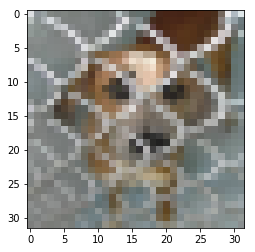

In [0]:
plt.imshow(X[4])

In [0]:
from imgaug import augmenters as iaa

from keras.preprocessing.image import ImageDataGenerator



batch_size = 100
img_width, img_height = 32, 32

seq = iaa.Sequential([
  iaa.Resize({"height": img_width, "width": img_height}),
])
 
def preprocess_image(x):
  return seq.augment_image(x)

train_datagen = ImageDataGenerator(rescale=1. / 255, validation_split=.1, preprocessing_function = preprocess_image)
#test_datagen = ImageDataGenerator(rescale=1. / 255)


train_gen = train_datagen.flow_from_directory('train',
          target_size=(img_width, img_height),
          batch_size=batch_size,                                              
          subset='training',                                              
          class_mode='categorical')

test_gen = train_datagen.flow_from_directory('train',
          target_size=(img_width, img_height),
          batch_size=batch_size,
          subset='validation',                                             
          class_mode='categorical')

Found 4500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


In [0]:
X, Y = next(train_gen)

plt.imshow(X[0])


In [0]:
256+128

384

#CONV CVAE 1

In [0]:
import keras
from keras import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, Reshape, Dense, Lambda, Flatten, concatenate, LeakyReLU
from keras import backend as K

def create_conv_cvae(height, width, channels, num_classes):
  input_img = Input(shape=(height, width, channels))

  input_code = Input(shape=(num_classes,))
  #flatten_code = Flatten()(input_code)

  latent_dim = 512
  m_height, m_width = int(height/4), int(width/4)

  x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
  x = MaxPooling2D(pool_size=(2, 2), padding='same')(x)
  x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
  x = MaxPooling2D(pool_size=(2, 2), padding='same')(x)
  flatten_img_features = Flatten()(x)

  x = concatenate([flatten_img_features, input_code])
  x = Dense(1024, activation='relu')(x)
  z_mean = Dense(latent_dim)(x)
  z_log_var = Dense(latent_dim)(x)



  def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0., stddev=1.0)
    return z_mean + K.exp(z_log_var / 2) * epsilon
  l = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])  
  
  models = {}

  models["encoder"]  = Model([input_img, input_code], l, name='Encoder') 
  models["z_meaner"] = Model([input_img, input_code], z_mean, name='Enc_z_mean')
  models["z_lvarer"] = Model([input_img, input_code], z_log_var, name='Enc_z_log_var')

  z = Input(shape=(latent_dim, ))
  input_code_d = Input(shape=(num_classes,))
  #flatten_code_d = Flatten()(input_code_d)
  x = concatenate([z, input_code_d])

#   x = Dense(1024)(x)
#   x = LeakyReLU()(x)
#   x = Dropout(dropout_rate)(x)
#   x = BatchNormalization()(x)
#   x = Dense(4*m_height*m_width, activation='sigmoid')(x)
#   x = Reshape((4, m_height, m_width))(x)
  
  x = Dense(1024)(x)	
  x = LeakyReLU()(x)
  x = Dense(16*m_height*m_width)(x) 
  x = Reshape((16, m_height, m_width))(x)
  x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
  x = UpSampling2D((2, 2))(x)
  x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
#   x = UpSampling2D((1, 4))(x)
  x = UpSampling2D((1, 2))(x)
  decoded = Conv2D(channels, (3, 3), activation='sigmoid', padding='same')(x)

  models["decoder"] = Model([z, input_code_d], decoded, name='Decoder')
  models["cvae"]	  = Model([input_img, input_code, input_code_d], 
                models["decoder"]([models["encoder"]([input_img, input_code]), input_code_d]), 
                name="CVAE")
  models["style_t"] = Model([input_img, input_code, input_code_d], 
                models["decoder"]([models["z_meaner"]([input_img, input_code]), input_code_d]), 
                name="style_transfer")


  def vae_loss(x, decoded):
    x = K.reshape(x, shape=(batch_size, channels*height*width))
    decoded = K.reshape(decoded, shape=(batch_size, channels*height*width))
    xent_loss = channels*height*width*binary_crossentropy(x, decoded)
    kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return (xent_loss + kl_loss)/2/3/height/width

  return models, vae_loss

models, vae_loss = create_conv_cvae(height=32, width=32, channels=3, num_classes=2)

models['cvae'].summary()

W0731 17:44:48.252269 140360791447424 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:2018: The name tf.image.resize_nearest_neighbor is deprecated. Please use tf.compat.v1.image.resize_nearest_neighbor instead.



__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            (None, 2)            0                                            
__________________________________________________________________________________________________
Encoder (Model)                 (None, 512)          3154912     input_7[0][0]                    
                                                                 input_8[0][0]                    
__________________________________________________________________________________________________
input_10 (InputLayer)           (None, 2)            0                                            
__________

In [0]:

from keras.models import Model
from keras.layers import Input, Dense, Flatten, Reshape, LeakyReLU, Dropout
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization
from keras.layers import concatenate
from keras.layers import Lambda
from keras.objectives import binary_crossentropy

from keras.optimizers import Adam, RMSprop

from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler

from keras import backend as K

dropout_rate = .3

def create_conv_cvae(height, width, channels, num_classes):
  input_img = Input(shape=(height, width, channels))

  input_code = Input(shape=(num_classes,))
  #flatten_code = Flatten()(input_code)

  latent_dim = 512
  m_height, m_width = int(height/8), int(width/8)

  x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
  x = MaxPooling2D(pool_size=(2, 2), padding='same')(x)
  x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
  x = MaxPooling2D(pool_size=(2, 2), padding='same')(x)
  flatten_img_features = Flatten()(x)

  x = concatenate([flatten_img_features, input_code])
  x = Dense(1024, activation='relu')(x)
  z_mean = Dense(latent_dim)(x)
  z_log_var = Dense(latent_dim)(x)



  def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0., stddev=1.0)
    return z_mean + K.exp(z_log_var / 2) * epsilon
  l = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

  models = {}

  models["encoder"]  = Model([input_img, input_code], l, name='Encoder') 
  models["z_meaner"] = Model([input_img, input_code], z_mean, name='Enc_z_mean')
  models["z_lvarer"] = Model([input_img, input_code], z_log_var, name='Enc_z_log_var')

  z = Input(shape=(latent_dim, ))
  input_code_d = Input(shape=(num_classes,))
  #flatten_code_d = Flatten()(input_code_d)
  x = concatenate([z, input_code_d])

  x = Dense(1024)(x)
  x = LeakyReLU()(x)
  #x = Dropout(dropout_rate)(x)
  x = BatchNormalization()(x)
  x = Dense(4*m_height*m_width, activation='sigmoid')(x)
  x = Reshape((4, m_height, m_width))(x)
  
#   x = Dense(1024)(x)	
#   x = Dense(16*m_height*m_width)(x) 
#   x = Reshape((16, m_height, m_width))(x)
  x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
  x = UpSampling2D((2, 2))(x)
  x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
#   x = UpSampling2D((1, 4))(x)
  x = UpSampling2D((4, 4))(x)
  decoded = Conv2D(channels, (3, 3), activation='sigmoid', padding='same')(x)

  models["decoder"] = Model([z, input_code_d], decoded, name='Decoder')
  models["cvae"]	  = Model([input_img, input_code, input_code_d], 
                models["decoder"]([models["encoder"]([input_img, input_code]), input_code_d]), 
                name="CVAE")
  models["style_t"] = Model([input_img, input_code, input_code_d], 
                models["decoder"]([models["z_meaner"]([input_img, input_code]), input_code_d]), 
                name="style_transfer")


  def vae_loss(x, decoded):
    x = K.reshape(x, shape=(batch_size, channels*height*width))
    decoded = K.reshape(decoded, shape=(batch_size, channels*height*width))
    xent_loss = channels*height*width*binary_crossentropy(x, decoded)
    kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return (xent_loss + kl_loss)/2/3/height/width

  return models, vae_loss

models, vae_loss = create_conv_cvae(height=32, width=32, channels=3, num_classes=2)

models['cvae'].summary()

W0731 17:45:58.963027 140360791447424 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.



__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
input_12 (InputLayer)           (None, 2)            0                                            
__________________________________________________________________________________________________
Encoder (Model)                 (None, 512)          2106768     input_11[0][0]                   
                                                                 input_12[0][0]                   
__________________________________________________________________________________________________
input_14 (InputLayer)           (None, 2)            0                                            
__________

In [0]:
# Отслеживать будем на вот этих картинках
imgs,imgs_lbls = next(generator_val())


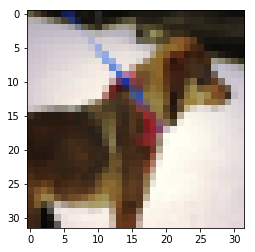

In [0]:
#imgs[0].shape
plt.imshow(imgs[1])

In [0]:
from IPython.display import clear_output
from keras.callbacks import LambdaCallback, ReduceLROnPlateau, TensorBoard

import numpy as np
import matplotlib.pyplot as plt

res_size = 32
def plot_res(*args, invert_colors=False):
    args = [x.squeeze() for x in args]
    n = min([x.shape[0] for x in args])
    figure = np.zeros((res_size * len(args), res_size * n, 3))

    for i in range(n):
        for j in range(len(args)):
            figure[j * res_size: (j + 1) * res_size,
                   i * res_size: (i + 1) * res_size] = args[j][i].squeeze()

    if invert_colors:
        figure = 1-figure

    plt.figure(figsize=(2*n, 2*len(args)))
    plt.imshow(figure)#, cmap='Greys_r')
    plt.grid(False)
    ax = plt.gca()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.show()


#n = 15 # Картинка с 15x15 

def style_transfer(model, X, lbl_in, lbl_out):
    rows = X.shape[0]
    if isinstance(lbl_in, int):
        lbl = lbl_in
        lbl_in = np.zeros((rows, 2))
        lbl_in[:, lbl] = 1
    if isinstance(lbl_out, int):
        lbl = lbl_out
        lbl_out = np.zeros((rows, 2))
        lbl_out[:, lbl] = 1
    #print(lbl_in)
    #print(lbl_out)
    return model.predict([X, lbl_in, lbl_out])

# Эпохи, в которые будем сохранять
save_epochs = set([i*5 for i in range(0,25)])

# imgs = x_test[:batch_size]
# imgs_lbls = y_test_cat[:batch_size]
n_compare = 6

# Модели
generator      = models["decoder"]
encoder_mean   = models["z_meaner"]


# Функция, которую будем запускать после каждой эпохи
def on_epoch_end(epoch, logs):
    if epoch in save_epochs:
        clear_output() # Не захламляем output

        # Сравнение реальных и декодированных цифр
        decoded = cvae.predict([imgs, imgs_lbls, imgs_lbls], batch_size=batch_size)
        plot_res(imgs[:n_compare], decoded[:n_compare])



# Коллбэки
pltfig = LambdaCallback(on_epoch_end=on_epoch_end)

##test 1

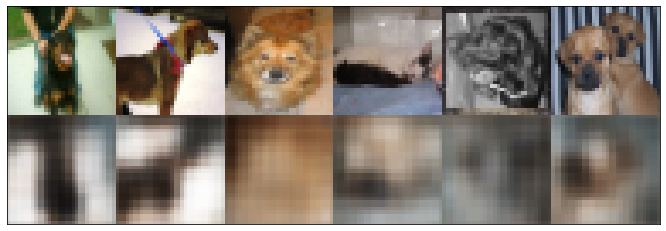

Epoch 102/102
70/70 [==============================] - 21s 307ms/step - loss: 0.3022 - val_loss: 0.3014


3066

In [0]:
cvae = models["cvae"]
dropout_rate = .3
lr = 0.0001

def step_decay(epoch):
  import math
  initial_lrate = lr
  drop = 0.5
  epochs_drop = 25.0
  lrate = initial_lrate * math.pow(drop,math.floor((1+epoch)/epochs_drop))
  return lrate    
lrate = LearningRateScheduler (step_decay)


cvae.compile(optimizer=Adam(lr), loss=vae_loss)

callbacks = [EarlyStopping(monitor='val_loss', patience=3, verbose=0),
		#ModelCheckpoint(filepath="cnn_reg_checkpoint_weights{val_loss:.2f}.h5", verbose=0, save_best_only=True)
  ]

#cvae.load_weights('cvae_all_weights_'+str(height)+'.h5')

# cvae.fit([x_train, y_train, y_train], x_train, shuffle=True, epochs=40,
# 		 batch_size=batch_size,
# 		 validation_data=([x_test, y_test, y_test], x_test),
# 		 callbacks=callbacks,
# 		 verbose=1)


def generator():
  while True:
    X,Y = next(generator_train())
    yield [X, Y, Y], X
 
def generator_test():
  while True:
    X,Y = next(generator_val())
    yield [X, Y, Y], X    
    
# Запуск обучения 
x_train, y_train_cat = next(generator_train())

# cvae.fit([x_train, y_train_cat, y_train_cat], x_train, shuffle=True, epochs=10,
cvae.fit_generator(generator(), shuffle=True, epochs=102,
         #steps_per_epoch = train_gen.samples // batch_size,
         steps_per_epoch = train_lbl.shape[0] // batch_size,                   
         validation_data=(generator_test()),
         #nb_val_samples=test_gen.samples // batch_size,
         nb_val_samples=test_lbl.shape[0] // batch_size,
         callbacks=[pltfig],
         verbose=1)
3066

##test 2

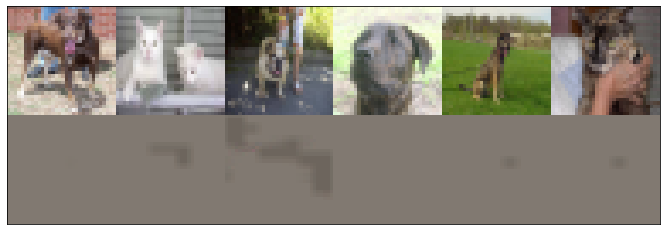

Epoch 22/102
46/70 [==================>...........] - ETA: 13s - loss: 0.3422

KeyboardInterrupt: ignored

In [0]:
cvae = models["cvae"]
dropout_rate = .3
lr = 0.005

from keras.optimizers import Adam
from keras.objectives import binary_crossentropy
import numpy as np

cvae.compile(optimizer=Adam(lr), loss=vae_loss)


def generator():
  while True:
    X,Y = next(generator_train())
    yield [X, Y, Y], X

def generator_test():
  while True:
    X,Y = next(generator_val())
    yield [X, Y, Y], X    
    
# Запуск обучения 
x_train, y_train_cat = next(generator_train())

# cvae.fit([x_train, y_train_cat, y_train_cat], x_train, shuffle=True, epochs=10,
cvae.fit_generator(generator(), shuffle=True, epochs=102,
         #steps_per_epoch = train_gen.samples // batch_size,
         steps_per_epoch = train_lbl.shape[0] // batch_size,                   
         validation_data=(generator_test()),
         #nb_val_samples=test_gen.samples // batch_size,
         nb_val_samples=test_lbl.shape[0] // batch_size,
         callbacks=[pltfig],
         verbose=1)

In [0]:
Epoch 2/102
45/45 [==============================] - 12s 263ms/step - loss: 0.3297 - val_loss: 0.3241
Epoch 3/102
45/45 [==============================] - 15s 331ms/step - loss: 0.3203 - val_loss: 0.3198
Epoch 4/102
45/45 [==============================] - 15s 341ms/step - loss: 0.3179 - val_loss: 0.3170
Epoch 5/102
45/45 [==============================] - 15s 343ms/step - loss: 0.3164 - val_loss: 0.3179

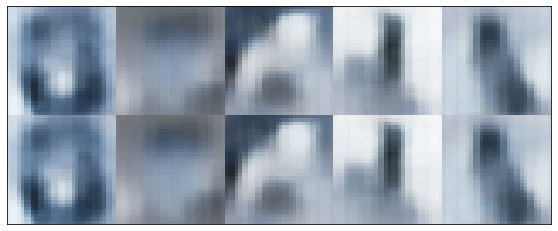

In [0]:
n = 2
lbl = 1
num_classes = 2
generated = []
X, Y = next(test_gen)
prot = X[:5]



for i in range(num_classes):
    generated.append(style_transfer(models["style_t"], prot, lbl, i))

#generated[lbl] = prot
plot_res(*generated, invert_colors=True)

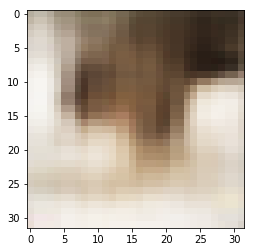

In [0]:
pr = models["style_t"].predict([np.array([X[5]]), np.array([[1,0]]), np.array([[1,0]])])
plt.imshow(pr[0])

716800.0

#Вывод

[Colab](https://colab.research.google.com/drive/15NycYTv8R0vNj0h40ZlcETRdeum05s2k)

Размерность скрытого пространства влияет на резкость и вариативность генерируемых изображений, при небольшом размере пространства изображения больше похожи на оригинал, но выше размытость изображения, при увеличении размера вектора увеличивается четкость и вариативность изображений (появляются лишние детали).

##pro

особых результатов добиться не удалось


![alt text](data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAApoAAADnCAYAAAC+L/bJAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz%0AAAALEgAACxIB0t1+/AAAADl0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uIDMuMC4zLCBo%0AdHRwOi8vbWF0cGxvdGxpYi5vcmcvnQurowAAIABJREFUeJzsvWuMLdl5HbbrXed9Tr/73r7ve2fm%0Azp0HhzNDDjkSOSNRpGJLjiUBsaLEjpRANm3JgRUhCSAjARIEBpxI0A8hjgMrsiLIgmBZtCjRVhRS%0AFCmSGnHenOHMnfvu+7797j59nvXMj+HUt76vuw4VIQcCgm/92qf3rqpdu/beVb3X2uuz8jw3CoVC%0AoVAoFArF/9ew/6oroFAoFAqFQqH4/yf0Q1OhUCgUCoVCMRXoh6ZCoVAoFAqFYirQD02FQqFQKBQK%0AxVSgH5oKhUKhUCgUiqnAnZTpVZw8bHjGGGMsi+dlWUbplGemI8jLaFd7nma8XEp5lvjktWw6p2XE%0AxXnJIuV6/CRxnEEpTPPz1UOvSC+0ayxvPB4X6UEG1wp8XgvLgXR5bXGTf5QkLC+D39INAH/zHH4x%0AD9LRmJ8/iul3As8v54/FGKdFZ4f7MsYYk25DHl07E/V1PWqfOB6zPFNidGCJhrPxt2zTv6hZAhxn%0ATzg/dNMDbT8J7LmUPiN5EP/pOtjXsX7lp5jUVnicJe4lxWNcj+WFMH4mXZtXRNaLzmHlKfy9/LAD%0Aj3ZC/UXJIpWJPpyy46BtHPm/NeXJK2Eb45yx04tkwUPrdOhJv4MwDNhv24ZxJhqLtdWEyeUvm/cX%0ALpcfmiz9y/9b5PAQ05TmKku8HHhbiXNANfBWdrs9UY4NeJZn2dCHS84tzy+B7YiHTZpbDoxpqIfN%0A+mn5u0EC39NY7mCbTnjfwk/23s9kX4f5b8L3Aju17Ovwe35xhdcRxu7GxlqRTuKYlet0Zot0WKmw%0AvO2tzSKN7/aZ2XlWznGoj21uPCjNW1w6cuj5jDFma3O9SPs+H+9z8wuHHrcNxxhjjB+EUMc5ljcY%0ADIr03i69l+uNJitXrdbp/FsbLC+Hl//MLNVpOByycr3uLp2vxr+RqvVGkb536/pmnue8Mc13+dAM%0AG555+m+9/7Bth39wDPtUkeE+77Q771EDREPqBMM9Xvl+lyZsx+fnD+r0ErTg8+nACwsGzNx8g+Wt%0ArXXp/Blcy+XX+p6Hl4r0P/wbz7G81atXivQbQ6rH7KkTrJxfoWvbdnmzJhm9fG+vbbK84c5WkY4i%0APngiGExJRvXPHP6xcAS+LW/d4gPk9r2dIr29T89oFInB3vhUkXZ93mnzvX9dpANox2HMP2pnl08W%0A6Qd3r/FzwD8Y+EHjiI+ASkCD88A/IjCT5Vn5JOy49DsMeVtVPPo9iqhckqSGA/PEhxs8zzH8o5CK%0ASTjPyt/Scw2qh29DfR35MqC0Z/M+jP8sVeGD0Rrzj6IuNGRtfpHlnVuq0jkceDGI+uILEF/Kxhjj%0ABHQOf0yTX+CJ5wID2RX3ktnwgYovKPGywg/Z8Zg/s60RPQvHovFYbdVZOWNRu/ERZ4zv0r05MM4+%0A9417vCB04lT812bn+AKnNjhz5iwrV4fJ2hLzE2srMQ/jS89x6D5tW/YdeGYTXu4OO78YdOwfqUxk%0AHf6xM/EfZpEXwwu316W50HX5SzqEudY4/F74xxTl/cEXv8HKJThWU953Aph3PGiPVMxxrkvtLe/F%0A9+kf7VFGx8kPLry25/H5qVGjvhrAs5XnwA8V+Wz7/f6h18L6GcPvGe/LGN538ONmNBqxctimmXgu%0AA/Hh8gHkPXvwz+/f/a/+KcurNGhu+dV//stFeuPBGiv3o//R3ynSj1y4wPJ++zd/tUhfv0LvpZ/4%0Ayc+ycrUW9bFf/2e/xPJazXaR/rn/5r8v0jdu8Pfcb/zq/1qkjxw/yfJ++u//oyJ99erlIv1bv/a/%0AsXInT9M88eP/2d9leW++/kqR/sPfo/fyx174Plbuwx95vkj/9q//C5Y3HtPz/PH//B8U6Ytvv8PK%0A/ekXP1+kn3r2oyzv6Y99skj/dz/zt26aQ6DUuUKhUCgUCoViKpi4oplbuUm89/978sV/UdUq/UdU%0AqfK8F48dL9LRbfrP5u1Vviz85jX6HYv/Kk2Oqyb0Z/kfG/4f2Wm3WN4DWNFEKj5w+ff1J87T6mQg%0AVgz68F/bg3VaERyL/7KPn6blZJf/s8j+k2T3IihlF/5zzD3+aDK475WHnyjSc0unWLmn6g8X6SjZ%0AZ3m7u7TCiauMt27y/8RurF4q0vcGH2F569HjRXrUf7tI22LJ0RnvFelGGLK8akhtPD9P7XZkeYaV%0Aq8Fxr7y+yvLihNafcljhdV3eP2Za9DBcsfqLVd7r03NOM7miROn+UMgdUnpOLvSrA9eyqKc6Fl/9%0AsFJadfQdXL3ibYp93xYLSDh+Urj0SKwWtpqdIn2iw8dtw6E2qIL0wc752LQtOE78q+rk2KfpuP0t%0AvqLRAolKYvHz73Wp75gR3WgU8dXZFFaX7/f4euStHrXVkydpVd4P+fOzYJx5vnhmhtogA/4wFP2Z%0A0aSWbKvDV97DgFN6lQqt1kh6H8/hCrkDlkXW6eCKJuaJFU1cdYW8LJNzMnY63q8SGI8ZMBZydSxG%0AmlOs+qcxPd8opr7o+VVWzofVt0MorkPrK2nNClCq8p2C/SyAlb+KoGFx9VeeH+d8bAO5eornOHWK%0Az+XLi8S0vfcOrTDNLy6wcru7RGtGoh7tgMY70qF1QX8itZukfIz0eiQ7CEDy0WhytguPGyd8PCLd%0Aiu2NK6TyWrL/YVuFPn8WiBjYQDkOcJzhUx+NeD3moI2llACfdQ73Uqnyfor3GUVCPgan9IA9Wmrx%0A8TIXUL0271xieXmC56S+PhKrx/huDiu8jki52/BearU7rBzOH5sb/DvOEe+Yw6ArmgqFQqFQKBSK%0AqUA/NBUKhUKhUCgUU4F+aCoUCoVCoVAopoLJGs08M/Hofb7fDsTOP/hEtYXWJuiQHuM/fvypIr21%0Au8PK/crnaCfgn75zm+WhJqBsJ6Exxtigaas4Uitw+HHzNa6x+tAZ0sJEI65rvLMBuswB6aMe3LrP%0AyrVapGmYnef6hhS0FDnsSA/EjrsUtDzSLsgBUV6jSlrGIyt893tlQLvlwpBraJr1o0X6+PGni/Sz%0AH+F6mjgiXcjOHtdjfPvGs0V6Y/XfFel7t66zcrjj/wf/5idY3omzp4t0a4acEGyHP5fePl17fZPb%0Ak9Sq1AHRPqnf4/qizR3Sq8TC7ilFPR00ty00JyAXNkHI/zdDay8LdGueI7RpqNkSuqF4CPWwDrcj%0AMYbr5w5Y4MBu5xh2YFeErca5BapjLRDWWPATZcy2sLiKQcM27vZZ3hh2e6NTgrTQikb0XAYjrsVK%0AUtTW4U5Zfo4cxNCdDtcePYDdlPsJ3VhV9IEgAO2iy3Vf2P52OoZjeJtO0mjiLnGUvvnCHg11n44r%0ANZqws1zuCC7ZGd9ocAcO7EmZsJnzYJe7Zcr1Vg7MtWkq5wz67dhUD1uMgxR2Jq+v3RV1RG0ntXEu%0ANMKWg/UV1nrMFqlcs/pTP/VTcC2hh4f9CLgr+sUXXmDlXMj7pV/8RZaH7b18lCxwJu1OlzvBUWO6%0AvLxcpGOhVR6hZrDERsgY3sfkexTvORE60jIrKOlEk8Fxcs8FaupRp3v9On9vvPH6G1QP4f6Bz9AH%0ADfkkja0cL0EIYxw0icMhn8ewT0hnDTw/vqflvIBzdDLg76+Xv/BrRfru5deL9HLIn9+MQ98jt77x%0Ab1je2hZ9m5yFTw435npT1m5CG459CZ9zo8X3u+A46+13WZ4cW4dBVzQVCoVCoVAoFFOBfmgqFAqF%0AQqFQKKaCidS5Y9mm/p3lfGmqnIIliyUMvx/0aUnX8elbdnGOO9v/8NNk5/DKVU5Fj8HawBOWHoiw%0AQsvVR5c4Zf3mu1epHFBVzz96jJ8jpLzrV1dZ3l1wEEiBurQF/XT1Ehm7j6OjLK/WIMoi8Ch9wIIE%0AzZcFXQS+42Z7hwxqz4m2QXufg5EmkG6g+tuCsrEgksBMh5t6nz5B59wbktWRY3FqYDwgyw2/wil8%0A26JnhkyPpJXqFepHd+/9K5Z3/gJFjXjx+0kGcOf2LVbu7dfo99YOr6MLnHgfKNrdATciRmubSWbX%0AaCOR+5yiRQpH/ne3A5ZJS3WQjIhyrH1E32FRbEBmUfd5uSr89gVFi2N8uEPPz4q4XQYaa1sO7zsV%0AMFu3UXNgCcoaaO+wytu0C9ZEKVh/7I/4mGsFEElLzGTnjlKfC2rU39CWzRhjajbdywGHNbD9cXKk%0AU/lcyKJnifbwQCqTe+W2PwHMYwfocWZNxK+N50HqrloTlkAuGOkLOQVeLga6UkZcwUvvowWVMSaJ%0A4FnAOKjW+djv94gKHIw4XRnBnOcCxRcEXFITRYebfxvDHZhQSiDnWqSpZR7SyGildO8BD4DxyPlH%0AinS1wQMB7O3x9vkA8rnjuJUG6Ds7NP+NhpS3Luxl8DhpF4RWPDWw32kJanRtnZ8Tge2BfeyJx59g%0A5Xy0Bytn8Fl7O44cS5SWNkul1xJIwFhf2u7VanVZ3BhjTDTicgS0FAuEndm4T22MMoAD1Dn0xbkK%0Af7bxffo2wRp22vwbKYSxWgmFJRp803TBFqq/xW2Q7l9+ufQcOGDQGqvZ5NIblO/IqEFS6nMYdEVT%0AoVAoFAqFQjEV6IemQqFQKBQKhWIq0A9NhUKhUCgUCsVUMFGjaVvGNL5jTxFLvURMIoxqyHUPfQgl%0Adq9HIY5OtLje78Qxsn04IexJru6IkE0lGA1I53Nnk9snNapks1QH7eKnHjvLynV3SZ8iw2R2M9CS%0AgQ2IsblGJAHbjqtXuGUDhnM6fZLCc7pCP+KBLiRzuG4N/yfo9cBewCoP0+UIvRhqKWwbNJq21Mmg%0AZY+oBdpJVej8d7a45ufkMbKMsl2pNgTbh4TqEUW8j9lwbx/72EfFOehZX71E7X3v5iYr1XDoHM89%0AyUNchqAJ29uia1/v8nr8+SrprXpjIeQDoA1GNuAiJdQlyTbtj0nnMwL7pFA4zeBglfZXTNyEYQTF%0AtVwftaL8HBsPNop0PQftUVWEGxzTcamwNqvWSQOUQxuktrC5Af1cIjSxlTq1QQPHRMzvBkOfJeJ/%0A5u0U60XniHN+L5FNGqhAjLnAUD/wcko7Pg/f56HtlNS9gr0PhosMRLi6ar1N5xf1cOD8lhOIPNBo%0Agu7QyqU2jepclaHyQIs6hrk7lTpjuBfXFmFljxweQlNq5OoPP0THVHg7ZtAfMZyf1FCGoIWTGj/+%0AnqK8z//RV1k5DAV54Bygu/OgTe+vcY3miVMni3RDaNq2treKNNrhyLbHe7ty5QrLu3z5cpE+CeEp%0AXRGe+Mgs7QnwhGXe1hbVY3X1RpG+decOK5eDBjkUOj4ML4rTjqzH46DZlM8M23iSXaEHtkXShotp%0AOz2hh8T6gvWWI8K5Yp/DK48jPgdZMLeEItx0YkijiW2DdZdXGA3590zeoLJN0I06IrZws0X9qt3k%0A42V/h8qGIe57EJZfdylUdGXMtaiBT/eJlnO1On+fY+hbqZHOJmhpP4CuaCoUCoVCoVAopgL90FQo%0AFAqFQqFQTAUTqXMrN8ZK3l+e9Sxe1IFl7FAsoePS9bvbRDccrc6ycp0mWV889/Ayy7v6Ei3zI82R%0AiRAjSCFeu87pAKQsfvRjF4p0u8Gpkrcv0nH/921uD9GaJdp7pUlL3PILPQYLCCkzGI5o2bwLNhVu%0AhS+1Z9COVZcvkwewdO0EVI/eDqeKvQbJETxPUHBAyaHVkS2oOsvKS/OY1QoQs8uiRV65Q+f/3oe5%0ATYoD1kqWQTqft0e7RW3w2Z/5xyxv2Cc7h909snu6+PJvsnJmh2h1T1DF0R7Vowe0wf4O7wNLQB1f%0AFTTvMD38XiQmyRGQItrsU1st1/n5LKBJXXGSDGhCP6C+cuYYt8vwgMpcf8ClJhWwtqk2qFxiS9sp%0AoL0FhZ8DzeSBs03D4eN2sEvtnTu8f9TAPiiNYFwJSigMIC/hY64FNksO9KuOoLf8jJ51YDjtiBYq%0AON81pHUQWJahNMEYYwKwJ0nAEq4JVLkxxswvkNTE5DIyC/wQVLQFv32kTYWkYeUERRDrzPJ5+PI7%0A75rDINUZTP4ho1tB+7vQF4XCyAxg3HoiOhJeDqncapVLszxmTSSo1xys5MCWRkbjwgg6cSYkO/Dc%0AI5jLPRGR5/69e0W6LmxzUNaBlkOS2t7dJRuxW7e4NRuWvX7tGtU34eMF7f+kDGBmhuRCZ06fKdKb%0AW/y9gXPQA2Hj1O2SJRXKFu7e4ZGdHnmY7J58YfVTRp1LS7tKiMeV0+/YNjJyWQ7fC7agzitVkgUg%0APY6RrYwxJktoflpuiwhIcG+9TXpmc0fPsHI1sE3sjbi1XmaIEkebuWqVv/cxANfu9jbLa8D4qfg0%0ADtwqn1t2wKrOGfJndnIG+ilER5oX/ciH5xL1OHU+GpXbjX0AXdFUKBQKhUKhUEwF+qGpUCgUCoVC%0AoZgKJlLnWW6ZYfr+t2jo8KK5oeXpnljKR5rw9U1ahn+0c4SVO9Umuuh7PnSe5f3eu7S0v79DS7Np%0AKqg6rEef12NplqiTT34/7Yjr3rjNyn3xIl1rUOE74xvthSJdbxJ10mjwXYZ9oFVqDb5jy6tjlAtK%0AOz7fuWkgWoqkppCysA2Vy/s8wL3XAdpKRgYCms0FSsFxJT2OkRvKaXUL5BRzbV6u3SUq5ovv8vv8%0A0Wdhx7sD5zNiuR7ov0rKKadxlX7fu/6ndMz+DVauv0V0wJvv8mgdGH3p4jb1HTvgfX0MtMqpZb5z%0APYUqbwMd3B9xOm4M0SrStDxsxhh2Vo9T4QYwYTd55tFfzp8/V6QfPs0pvXqLpCDHznGJwIPbRAVm%0A20QJWUM+rtwqRKtwhZTFgDTEJ4o5jcUOZuje7Ranol2IIjSMqA8MBT2ews7nPOT9I4Bd17MzREfV%0ABDUVAgUn/QSQlcU5bbYzz6+FdLnF5yeM9hXH4Agh/sXHSDUyEhpeW/adNMNaw7WFtOLmVdrBfO82%0Ab28Mz4U7vw9GFrMPTcuyOfROweCbaEDzpO0KyhNo1Aq0h4ymg3S5K6holFnNztNYTZLySF2eiIwW%0AwzlSOE7SvEh11+t8nOHO9XWIuiPPsblJ754jR/j7Edv4HtD0N2/eLL2WBNLNJ0A+gdF+jOEUvqwH%0AAnexS5p+f58o9lnRpng9rG8k5AgoM5B1RPBri13WMNdYor2xv/gwVrP1b7NyN/6Idmo/e5TLAGoB%0A9Ku3P1ek+5unWbm/82mS6732Hn8vjVOaJxPYkf7SVe5Yg9KbTz99nOWlIA8KUBIgnC9imDNclz+X%0AVkrvLCuj5yLHvo/RkfZZ1oFIQYdBVzQVCoVCoVAoFFOBfmgqFAqFQqFQKKYC/dBUKBQKhUKhUEwF%0Ak+2NjGV8631NA1qmGGPMcEwag/0Bd71PQQvYgwgjX7t1jZU71aKIBueOrbC8Zx97jI67RhqXdGeD%0AlbNTuvbJJW7l8qknKJrCr/z216jum1zX2B2C3cKJDstLK/T77IdJ4zI/y8u5oDcKfN5WGQiyssyB%0ANNePoD4qErpXlJrEYPkSxVzjwvWVTnke6DJdoZVCeYbrSosJjFJClXLFtT7xKB33q3/KsswX3qS8%0AH3kWhXBck+PBpfv7XF/5zS//VpG+d5WifjjCpuLyFbKVeOsB15IsVKj710GDYlX4Pds2aX7qhp/j%0Ax//hLxTp7d37RfrWKtfa3LtNFlp372+xvLfeI/1VDn0gE9FdXAufmYj8AtrDo0coPcy4Jqe3Rlqs%0A2VmuJZ4/TprpTYjm1L+/xsrZCY39POPKRhusYuIY+oeYP1qzVMfxQOhZoa8nYHVUFdGFrIB00rUO%0AH/sLM5SXRDRHJMJ6bIyab6FfykHDi1G8RCAtY8GYcMT/7pZz+HiXGii0KUJ7FmOMwduOpB4Pomdh%0AtQ5EZkELHDHeM7SDAX1l4MsoNofbyxjDNaaIWEQisXPUkPM6pnBtz0ZdGT9nAHr15ZVjLK9aJU+t%0Ad7716qF1Mobfs6x7PKL+jfqz/j63qEE9qNRoohYT86TuECM2SS0qngN1jfPzXCO8trZ26DHyONSK%0AyghF58/THgnUScp6jaBtpO4VNatyD0NZnfb2+LyOrZPlwnYK+jRrK6tctxyNuKDQ2blapH/so/T9%0AEeT8G6YGFm5hk8+TVRgH9Tb1t+Y874u4nyEe7LK8S/epLx1bJLuxt+9cYuUwWF4WiyiAYJ+0vU97%0AEbpr/FouaJptMW69hMZn3qX+IaYnE8j9JIBk/N2jOOqKpkKhUCgUCoViKtAPTYVCoVAoFArFVDCR%0AOjfGGOsD+i6V7vtAaTkiCgDk1cAWKU745e52yen+aJPbxnzvCm3Xf3OPaHV/jrvv93u0ZPzwQxWW%0A9+VXX4NrI33GipkK2Kk8uHWZ5c0tkd3RkdMU+eDsygIrh3SAjNyAjiTI3EUpLzcGmskTFN9gSHSG%0AY0F0moyfYyJ1Dj+RLhcsm3GA6vdEpBMH6ADHh3IH7E4o/dOf4Of/b3+bnkUboiP9wJP8Wtde+nqR%0A/uOv/B8sLxkC5eKVWyT1xhBhxON17AJt2qqAhYzL+zNaR+wMORU4O/9wkT770CeL9JNPighCI5Jr%0AdPd55I2/99mfoR/QV6KEU0JWCNFpqpzue+wU0S8taFOnxinle3cpMsT11y+yvEaV2iAC+qwiotgk%0A0L8zS9A5Q6KEHKh/lvF2S+H8ecDHreOEkIa5pCOo/qM0Bi1Bw/YHNC9kcI6RkGB0WkTx2cJWKMM5%0ADzq0HFeMBp9gCeQAhZUIyUEOEqBMRLvJE5CrCJqQEaVw7QPUOQz+UFiW5Q71l3GCUVt4OaR9Ja2Z%0Aw7jLIYJTKiK5sagwB0JkUXIMp/eERVIKcqxelz/PXYh4kwDVKJ8ZRpRD6tkYY7bB6mc4IOp8LGxc%0A0JoHbYqM4ZQ4Uv1oD2QMj8KzuMit9fA4pKLlOZaXKaqepObxHDdukMWOlG4sLNBYevrpp1leCLIi%0AvE+0XDKGt+Px49yKp9MhqVmrReP4wHNBOVlevg7GI63xc+D8dOO1L7K85ZDm5SCkea1aEbIckAV4%0AdT7vtFt0nA0SIyknwTmpKvzMOobmJzOmfvo9j59k5UYDmk/XdvssL4MBdPkBjYPbW1z68NwZ+raq%0AiCiOWUZ13r/7Hv39qe9h5fwJ1LmU7x0GXdFUKBQKhUKhUEwF+qGpUCgUCoVCoZgK9ENToVAoFAqF%0AQjEVTNRoerZj5sP39Qm5xzUdHYe29Vc8rhcLQtJcHWmRRmyUcC7/7QFZD6wc5SEotzw6/8dmSct5%0As8stJm4MaUv+y29w26JZ0BdaoInKZegskDlaPW6HkD6gcF/7fdJt+B63h3Bc0HQIfWUMIbEi0Fjl%0AQleWgWZQhppzQOvUB91Gf4trg5yzGCaOPzOHaTTBKkI8W9crtyCxof6oOZOaMPxZE9rI/+HH6Li/%0A/U/p+UVfW2Xllu5/pUhvbHJdYwTht9qz1P8qLm97DMcVBsLGBNIfhFo1xhhfaMIsC9rD5c/9j77w%0Am0X6b//kzxdpt8J1h4EHeqvarClDBs95IMTEOYZcFMdVmqQbGmZ0L4P1bVauCiHNXKHvHe+Rtmex%0AAe3R4PdSa5C9yqjP9UDrV6g/Li1ACEphhZLYZPmyG/O7YW4ZYKGVRtxGw+6C3qrG7caaszTvpCPS%0ALw17XOeE2uqKkCGxLg2DR+rbGMSDQRudHP6vl1q6DOYnqTfF35a4AFqooP5RRjnN2fWE9hf0m0FQ%0Abr+G8KTtGdSR2RSJcmNob0uOMxZCE9tKhh2m9r+/xueF4ZCe7xiEnvKZoV6x2+fvFAd0bBF0Rmlv%0AhM9wLCxeUBt5/z7Znkk9KD4zaVuEIR1Ry4iaSWOMeeihhw6tkzHGvPce6e6wjtKaCG2cUF9qDA9d%0AiVpL1JfK87/11lss7+TJk0Va6jL5OcBuJ5dBYQkYQlSGmRysk0VQz+X3MjsHIaBBUtlZPMnKZWCL%0AlAlNs2tRHYM2WRrZYsx1YQ9KZ4mH9dwAreve3k6RroXcJuv+iE56b32H5Z1Ygu+pnPrb2g7vi/e2%0AaP5bnON6ewf2I+D4y4VNIFqASQutaMz3IxwGXdFUKBQKhUKhUEwF+qGpUCgUCoVCoZgKJlLnlaBi%0AnjrzhDHGGOG0YtIcrHhERI0Ios7sO7T83YslpUwn/f1VbpVw4iQtNf/ER4lWv3qPL9f/3K+8TtcV%0AFkzBUaIoGx4tBe9GvL4DoFhsYTvSXyfqfGcbIhSl3GYJ6ZYDzBrYEDD3Bos3//q920X60rdeZnnb%0A63Tf+12ytxjtcDrnP3z+s0XaFZR1APY4SIlLit2C/z8cSRuAhQOLEiRoMKTVxUq7ufUKhQp65M0v%0AFOlfGP8gK/fTDegTjrCfaEPkEKjiMOIdNYQ2sGRIF6jY8RMk1Th5hltX/f6XKJrEbIVbWPTfe6lI%0A/9Hn/lmR/ms/9jOsXAiWQ1IWgVQE9p0s5W2fQOepVCSdTTT1AKjAO5vckqUOdkSdCm+P48t036eO%0AEyXU7vAoHz2Ql7z3+tssrwqWVyOw7ahUuGUUyhjOnTnL8rIx1f/2beoDN+5xGUB3RNc6eqzJ8kxO%0A5/AtolPtjNNKlkPtZtn82aIcBCUYeS5pbzifEdZBBscBRAoRMiKkMtOUDxhWD0GrIyXOcoSUBWU6%0AYyHtwcghGOnJtmR7ULnxiNffgrk3Qds2wSf6MH9k4j7HSOfCtbrCwmhwnaLD+S3+3DN4pWF7u2Ls%0AY+tcOP8oy7PAiubdd98p0mhnZAyPTiOj+iA9vAt2SRhZxxhjTp2i6HVISx+oP5xflsPoOjMz3CYQ%0AgfSnpMf7fRoj16/zqGazs4dLfeS1MKIQ0v7G8LZD6yMpJUDbvWjMZWGWRfaC2BePz/F++sgc5YUp%0Al/bsdalvnj1F804o5tM4JRnesC9shXyyO4q2yS6uNsctndACLIt4e9RAUtjr05zkBHyedB34bol5%0AH7M3qS+dmKFx9n1PLrNyLbBuur/H26MOpwwW6ZvGq3BLJ09EO0SMR8PSvKKu37WEQqFQKBQKhULx%0Al4B+aCoUCoVCoVAopoKJ1LlXrUWRAAAgAElEQVTjuKbefn+JNxW0wbZNy8IbY750GgNLUa3QMv8T%0AD3GK7OQcRfz5whdfYXl/8xQt3XZqtKz9lTd50PljTVrSXRtxSmi0RxTLC48vFelXVnl9HwyBQp3j%0ATXIfdlBWK0Q3uAeWkpEG4nQRsjYOi5rBqaPZeapjX0Qw2dsi6jwd0fJ3HHMqxoYd5Jbgs5Hxs0E9%0AIKlzZNzlfyK4e9+2y+UCuMtza3WV5f37f/w/Funb6yQDaM1eYeW+tPBikT7V4/e5VKdnW4dd0cN9%0A3vYubNCMBIWPkUmOHKcdn6dOc0roB56h59Liqgvjw+68m2/8cZH+3zf4DsHP/oNfKNKBiISDsFgE%0AGt6oVYhc02lz6qvTIQp4Y4so5qjPnRjcOt3AydN8J+SpFbrv2Qo6D3A5CfadR0/xtqq59JySEbXN%0A/CzfrT+3RHRcdY5T86lNFP7sHKTnOc12Y40ord1tPl5GIBNpwxxhC4pzf0S0lVfjHQR39zpu+Y5x%0AfGa2GAgVpMJAVpBnvB4JjGmheDEWSmxEhBEbqHkXd/MKWjoFCjsVu6dtFiUMpSa8jizySSLmFpfe%0ADym4JWRyBrH5HF2GIURC696+w/IG4LqxUOe7dF3/8B3NB6QmQB0jpWyMMah+QEkDOhQYY0yzSbT9%0AysoKy8Pj8PwyegxG9ZE745GKxp3l8hyXL1M0O7kTHOtRrdIYxOg8Mm9nh89dKAPAOkm5AJ5D7sK/%0Adu3aofWXu99ZuwU8qhnO140q9atHl/gu/BFQuZ0ZLjPA96oXQgQ1w59tDG4RODaNMSaG+/ShH7kB%0An+Nc+LyKxTnmZqn9t7foXRb4nDqvQbS2LOHSIYzq44ALy7kjfD7djaitNm/zqFJrCeUtL5S/e/yQ%0A7k16UcTCDeQw6IqmQqFQKBQKhWIq0A9NhUKhUCgUCsVUoB+aCoVCoVAoFIqpYKJGMzHGbH5H2DcQ%0AuqTFBbI/OT+3xPJOHD1dpDtV0rE4wmIC5IomdrlNyhZEarlxmSyG3rq8yisJ+pGjXCJhnj9FGowW%0ASB8aIgLINoiiGnWukUjqdG9LS6Tjk8ENLAP2NUKGlGGEA5cUDnbGv/M90Gdc+PBHWN7+GrXBsA+R%0AN4RiAi0xbNHeLMIIagFdaYUCdjviXxHU66ANiCUtkuD8r/6b32V5d12IUHGaNFbnW7us3GiGrvWt%0A2k+yvMeWf7VIex70TYfrU2pN0vE9uMQ1Lgsdau8lsEvyHa5JfObFp4r0cOM2y7v9Gj2XZpU0M199%0A+9us3BC0TUGL6ytRF4fpRoVrx5ZXqP+dP8etNHY2SecTgy5zQbj+nD1Ouqeay7U1vTWyEvLapCFq%0AL3AtZ7u1SOcIudar0qI6xhD5q9kRdhmgdzYW76dJQhqrEKJ7+U0e1aI2pLzuBtdALRw5StcCS6M4%0A5x06yamNR4aP/TynelVBmLq9xa3YfJ8mlPkZbgWDEWLCkOobCH1bA6JxOW555BTbKR9nqA8VbnQm%0ATUg76widpwW2KcJRi2Hcw7PygiP2s1znacH8kYp3igHLp+0rpOkbxXw8bg2ofx8Teme0MMOoTFIz%0AiPpKjNxjjDFj0Jzt7dG1ZESUhQXSD8/NcT0hey4wpns9ro9F7ai0T0IdKdoPycg6aDMkdaR10LCi%0A/hG1ocYYs75O1n3Scqjb5TrvDyCjweG9yPtEPSe2t9SbemATaIt+2t0l7ehobbVIz1f5fDroUr/q%0ARrzvoP1YAqGBMIqUMcakYMWYinOM+zQ/4XEXr3It8cox2pMSVPn8198l6yYf2iYR0eDihJ6nJ9pj%0AH/qE69Pz5D3AGAuiDZ179q+xvC/++98r0oug65aWhKgzllpi2W8Pg65oKhQKhUKhUCimAv3QVCgU%0ACoVCoVBMBROp82pYM0+ff84YY8zxY6dYXs2j5WoZrQKjUtjoSSBo3ggorUqTLy3/21deK9IPR0R5%0Apn1Or66u0xL9UyuCjgLqAVek3YzXow3L990hXwYOFukc9SrSNDICyOFRHIwxxsmI6nDBHigSFG0G%0A1kRHjp9keYsnyd7i9jvUNlYsqDR2azLiD2RCG1hinRwpC1fQ6kh17HYhQszF11m51/7sy0X61Tde%0AYnnbbaIax0Bv7Q14fY+s/36Rnvc4PbI+JOr4eINoH9/ndFwQkp1FLqI+PXWB6IZWk6iBZMijOPhN%0AomG79zlF2zkJdG6PaNL/+sd/kpVbWqJrJTFv72qAFDnlSYozB1pwDaguY4xZaNM5jsyDjUmN27/U%0AoM+lfU5vJVWi4MLZc0V63ODSGHDVMK05Tl22XGqDHCLEhC1ug9QHjjYac+uqUZcoqK0HFHnD8/g5%0AMELKSHC+Pvz0ParTKOTt4btU/8QSmpoM6CKIOLWzwS1kjq1QX1zocK2CD/IH36N0pcKvJelQhAv9%0AwPF4uRzGTwb+ZZ6g2DFCj6TFkAmzYL5OxXjhEg9J4QNdDn04yziR58Nxns/nyY1dsl7ZWIP+HfK2%0AugcSj/MiKokLFmBWBpZLKb8XtPdZ29hgebt79I7B+W7l3DlWDilEGU0HJRNYbhI9jhF+jOHtjdR5%0Ao8HlQXjOVWElh/0K5QKyvkiPS9r77l0ag1wKwp8L3ue9e1xegu9EvE95L/KdhXj5q39YpMe71D+C%0Ao1y2MPSorUYDTvuvLJEM6PYqjeO5Nh9XFYf6sLRg6u1Q/XfGdNzl+/xar12i8587yr9vrJj67dY+%0AzX91/pozGzv0vkkSPpYaEG2tAv0ot4RF0sKJIu15XDKBSOE+pU1bAO8oOX/IaFeHQVc0FQqFQqFQ%0AKBRTgX5oKhQKhUKhUCimAv3QVCgUCoVCoVBMBRM1mkEQmtMnHzHGHLTcsPPyQ1O0zoG0Jb5rPYd4%0A/1mhbbo4prwQJHNbXa6RQ2ubgdC+XVujvPoy2Y78Jz/8w7y+oN/5k5e5nvBVcMVwLAhlZ4kQlHCf%0AqdBSoOyEWQNIrVRebgty9gJZ7Kxdu0in4NIj0wMtT3+D61l3QNeyu7sLaR5yDDWanTbXxd28Q3Y+%0Ar/056TDn61zHkoPeY2+X65IsGzRcQyo3FtrZHYfa8eHKH7O86B3SpIzr9Cw8n1/r7hZpYXyPt+kI%0AQiSe/TDZPpw49UlWrtIkDVD0Ar/PtQekdWp0KAxdrca9tuIInzu/T6fECkVqn9MePadgaZHlLUEY%0Ax3aD7jMTeqshWHO4LtfybGXUpq+/dKtInzzONTgf/RBpfnKHWzDtbFMdvSppKNsrj7Ny6xBWMA34%0AObw5qlfvDmixLD72j4OFUbPFtV5o0TKE9h3C+DDGmAzmtarQTAcB5Xlg73Hi2AlW7qGHztAxPtes%0AOtDnHBvnQqGLtg/vA8YYYzMNpew7oLmFiSZNpXYb+q3oV65DfRV1noEvNXh0nNQ8op54OIQxJ0Lq%0AoU5VWg69e/VqkX7jHbK7GwobpPoM6d36IpxmBnX0Y8pDbaExXIMmrYlwW0FZeE5juG5Shm3kNnMQ%0A5k/YCmG9jh/nlmWoc8T5epLNkqzHBuhPUSe5uMjnDwSGkjSG6zyxvtKaCOso+wfaLqGmVJbD92Mi%0AnvvNVQpRHIwHcAyf11PwTYwjfo53QJd5F16Pj6/w/nF+heauqtAS9/pU/zsb9HFybY/rvy+v0ty1%0A0eP1eP4h6sPvrdL7/JknL7BycUznSMTL3oF+NbNA/arSFHZP0FZ+vfy7DcejlfP6eh62j7Q3koZK%0AB6ErmgqFQqFQKBSKqUA/NBUKhUKhUCgUU8FE6twytnG+Q43ZksYDPicQkT3Q6idDSijlS/4WXP74%0AIqcvEqBtXt4kCmQz5lXeiYiKWeMsivnQEi1xZ8C6nTnOrZraEF2i6nI64LWv/lmR7kLEFdvm0VKQ%0AB5cUSyYjYBTgS9B4nCtsTGaWiZY9+vATRfrGm6+wcv/ov/xPqb673G5hOIb2mCBp8OGnJ2xXRkgJ%0AQd7OLKdblprUjvWGsI6AR3i9Rw+mL1bgmwkdd2njKsv7AUOWO2tfAgrhBd6PmhAGqlbhz+En/t7P%0AFennv/9HinSScXocH18iopS02h8u0jGEhJI2JplDJ8lSXg+8WuDSc5GRgZpgfzVb4fWou2C/s0b0%0A0KDH6cl6myQkzRanz/KcKJfhLkkCbvW5/cu5NlHp45wPuv09siKrgxTixptfY+W+8S2ihN5Z5ec/%0AukC01TPniBZMu1wKYsdEXc41BWWdEZV+8ya1hwgAYpoB/aET8DatVSgP2bPTZ06zcq5DmZaIxoVS%0AgkWgOD1hgYZUrjMhypbJuIxhHNP48VygwFNej2hMbVWtcpmBA1YuHtTfE3NQBs/TEXNcCn0/B0sj%0A23D6fXeT2uOdS5dZ3pe+QnPtFkROsW0+Jx+FeSePeP9OsI4wX8vxaCHtOMPlQbv7dFwYUP3LIuQY%0AY8zKygr7jbT3pOPQZkna4iGFjXWUdPOlS5dK8/CdwqzpdvlYQgsftA0zhr+/zp6laDfSkuuVV+hd%0AJN+BWBafhbxnfI/6Ds8LQqJv331ntUg/foK3fQT3clPIx7Yjmice9InqdgyX1MzXqdzKCS53GOyD%0A/RXIwHrbImJYRs/9o+efZXkXgCL/d18ju8Kwzsfmj/z1TxVptBM0xhi/RmUx+tlQvKPGY6pHc0F8%0Aq8En2XhEc0kqqHM/EFJBgEYGUigUCoVCoVD8lUE/NBUKhUKhUCgUU8FE6txYtAQuA6kjMhlZpmSD%0ArTxHApEnzs1zGs8NaFm72qal/Nk+j55wb5OWk9fEjrten5aJB/tE0/yL3/k/WbmnH3qUyu3y5W/c%0Acfb1t28U6cfOiigRLGpGOXWOadkeeY50Nl+qzg0tT59+nJbht26tsnK7r7xXpNNc7C7FOhpqe7H5%0AndUjTQQVAxRICGGIoh6nHrYyon2OnuJREdoe0CNwrZGglD2g9HYSnre+R9TrSpUcC+7e4bKI4ych%0AIkXK6f1nv/fTRdqFHcZGUPgp1EuOAozyY8NuR0kJ5UDHH4gBA/3Ah/adb/A+4Nv0LO7e5TRKAP20%0AXSOKqdbglPLSCaK+jq0cZXkP7tFO8Cd+5IUi3X9wg5VLR/SsN8d8J3hvALtLE4r00jC8H507QWN6%0AYXGW5Tmw+3swojG9s8fvuQsRKVozCyxvZoYiNrnHKG99i88fXkj0U6PBd2s6QNla8OSjMe8geyBR%0A2drZZnlf/vrLRfpvfPr7i3SzISIUATV1gGqFOSMMeO+Zm6H62w7t9g4q/PzRiKi1UERHyoBu5RQn%0Av0+k0m2bzxrjEchyYNLvC0eLV7/9bpH2Pb7TNwG6bhhRnVoVsSP4ofN0fhFNZwzSgvq4/PWG91kR%0AEW5WjtK4uH6D+v6B9xdQtHIHPe6yxgg68tli1B25mxypc6yvjCCElLg8R6VC4x93vG+IaEj4XpK7%0Aycsiv0jqHK8lo+lg2+FxkuqfhPNPPFOkX/k6OZ68dnmVlTs1T+N4cZa/e5Zh9t27Qs4URxe4k0QK%0AkejeuMSjsGFbzYG86bmH+Rw0iGgOevwcn2vrHZJCPHqGqP+KI7Q9e7eL5GKDSxqcCr3PY3AMsYQ+%0AaHeD+vDW/WssD2WOYyZD4X3dA/cI2ccOuOwcAl3RVCgUCoVCoVBMBfqhqVAoFAqFQqGYCvRDU6FQ%0AKBQKhUIxFUzWaOakR5D6FNTqSQd/eY4PYAkxYAaZYcitXKohVc0PSKvi1rieJhqTLsnKeB2/sUr6%0AsZ94lrRM3772bVbuz0HDMBIReXo+6Sfu3IVoI0OuyalUqV5Sw1Cmb5V/d8DOwU64TgbtUNCe5Djo%0AVowxxvxfZHUROPz8PsoQwf4kzUQkEtBfucJqJYWHmIG+clvIeEZg2nNMaHl8eIb9iPQvwiXLRKAx%0AjYV+cwh60zE29xqvyA/8Fz9fpH/2mUdYXrOJdjCH69QkDj5b0GgyyyhpUUNpaXflQxvPgk1PO+TX%0AiuCcrsefWQv0O0dWQO+c8X46zEhLtyXsMjKIPHHj7Vep7g7XyKH8dNDj+hwcFlu7dP4li+sf3ZDG%0A5tE5rtG0QJu736XzjwbiHKD7RL23McZsrJM9zs4WaUVHQr/U9EmvaPv8/Cx6j0vz0/YO17f98Z9+%0Ao0hfuck13hH0q9/6/B8W6fGY91Psc8JZxFR8mgvmOtz+5Ngy2XnhHDE3yy175mcg8poYaI0mzDtQ%0ADzk/xRMiuoxGNA87EHFqe+M+K3dklupx4jQfj5vbpD385mtk+bI8N8/KnTpLOuzbG1yv+JBN/aoN%0A0VKk7hB19DLq3ews9ce9Lp0/FbrD69fJAkzq8peWyH4N9Zr4d2OM2d4mTe+1a1w/t75OcyNGW5Lz%0Ax/w8tU8o9Kb4u9mktn/ooYdYuTfeeKNIy7bC47AeWzCujOGWTrKOeN84h+L55HHSKuz8488V6ZlF%0Aei+/fZ2PueUZ6leNGa5rPD1Dc74HUao6da7fv7tL9bqzwXW1GejtkzmaM47O8zH3EOwtsSzx/uqT%0ALdyZ06QPlTZtCdiX7dy/w/JyqD/aesXCbiiE9+jalW+yPJx38DjZn7FPyK8Zeb3DoCuaCoVCoVAo%0AFIqpQD80FQqFQqFQKBRTwUTqPDd5scxti2VspAZtQTXmpoRKF/RnBhzRlqDgIiwKVE/VyIgaUFBQ%0A8/d2aUn3K5doCfpsmxe8+ICc/q/tcUooWKLrHb1A5xjHfLk4yGgZW9IG+BtpA0k/YR5G4ZB5yGYv%0Arxzn5bA5hAUJNn8MMgNL0OO4au64glaHdAwXczPeB8YQhSgaCap4geicMdyXJ2jpbER94qTDKYUA%0A7GGcnK79yH/AbSSefpGkBbYj7aTgekDX5qLtUZLhyr4ODZIC9exIKxS4liPGUgiahhmIVCNtV2oB%0AXWxpmUdAqoEMoFKDtrI4DTbeob6+uc77cBJRPdbXyJbm1PmPsHL70D5v37rL8hwLLE72qT2GvrDt%0AiIkGmh/xcdAAeng0INpK2iChUZRgok0SE20/6hMN1h/ze6426cBUPHcX298mOvgbQOsaY8zF1Vt0%0AXRn9DPoBShXkHIHlfEFtY8Sp/QGnGm+AnKcSosSB1+PEEvWXI0urLO/cGbK8uvAYRSyp1YRUAfp+%0Ar8cjQvUHpJloN+j5hXV+jnaTKM+wyiUZP/gDLxbp2Vmq70svc7rv9dcpAs0nFrjkqrNAUZtmQpDG%0AiPau10EyIazIhtCZZmaozyUx78No+4P0sjG87fDa+/tcroKU5PPPP8/ysI0x+o+0G0K7IyntQVod%0ALZjkOTDij3y2GJWo3ydrM6TKjZksEXjkEaKzHzx4YMqAVK6kzuvQxmfOP1mkv/4nf8LKvfweSRAe%0Ae/gky3vsOLXHDNjAbY+4xOjmJr3rI+HA5PnUr9bgu2Vuhs/53S61VWfAJR57OzSvuSBnyjPen0Ow%0AKWvP8vMPQHbgw2O36/y9EafUvyNhE3gUIvoNoH/IfuSBHEZ+30krq8OgK5oKhUKhUCgUiqlAPzQV%0ACoVCoVAoFFOBfmgqFAqFQqFQKKaCyfZGxpgPtD55zoUKaQp6AYfnYfg9Fn5RaAGziLj9P7t4k+WN%0AQEswAAsZJ+EaKwuknagTMsYYdCr6s+ukSXk953rQDESJsQjbWN0nnYUNNkCW0DBM0ilw7eXh4SiN%0AMSYGDVCS8nsx0P5YRc/neowR2LyEQjcZgx0RkyeK54LhDEMu8TMpaNA8iyoyiHh7oOyu2+XPrIK6%0ALdCjuUZooKBNvUhYJHnUPvugh0pjHgozBi1tYHMLC245ATpaU66fyw8E7ISyFo4DaV0F9jXi3zvX%0AoT+EoCur1XiowOUFCmmWu7yO/X3S/OyA3rTW5Bq5MWiRxsLW6v42aX6e+vgPFemVMzzc6i/+898s%0A0ru7wp4kpfZ2XOo8raUjrNwi2IykNu9kDvT1TovqX6+I5+dS398f8j62epO0qMalZ1F1uJau0iYL%0AHEsEB7VA34p95dpNrkvFKK1S28Q02Ul5H8P+IUP64jRxQD8MY3e3DxorObdEZPd0f32X5X37Itm7%0Aff2bZHPz4ic+xso99iiFfqyEvF99+20KLTlXIz1aZ2mZlevuU38JQ667xvnv6g16H4xjPl8fWSZd%0AepdL2szJWbKU8XbIfkeGhEW95WyHW+AMwDIPnwtqFY3hISKl9vLYsWNFGvWVUvf6mc98huok3iF4%0AzvPnqe3feustVg4tjNbW1ljeO++8U6RRe7m7y/sA1mtujuu/j0JITtRXyj0GaImzuMhDSiNQHyrP%0Age9EqXPHsdSeIQ1oUOH9aHtA53/n4iWWd3oO5h0IuZjZbVZup0vWUn6V38sANN+xQ9da6/J3z9il%0AOWm2z5/7ICfNYw/CN3s57wPVFoXQFEOf2TMl0I55ytsNQwZXK3yuffQc9dNvvgPaWdH2rg8DTWzB%0Akd8xh0FXNBUKhUKhUCgUU4F+aCoUCoVCoVAopoLvGhkoid9fQnWFzY0DVjGScspg6TYVETsQaDez%0AI+wFcoz8AtTJeHfAyoVAX0TCoX4IS/SuS+vOI/F9bSGlLO4TOeYhLLVLeyM3paVlaV8j6bSyv+fM%0AAocvcUdIpUM5GYEGH6i0WmGhmeCePXHPSN1ZguetAM07AtsVGYXIgue3vsatHbo7ZJ0z16F2i/b5%0AErwL9kxXXG7HcQOe9WMNutanBc3r+2jLICIYQPug1ZaMiJLAfebSogupHmibTLQ90kqxsElBucYu%0APOYjDu8DlQZRZG6fR6cZAGtThUgyrriXhUWiwfZ7vE1Th6w/Wic+VKRHFU4Z+kBV7Vy7zfLwzhyQ%0AVoxcTnvPrBCVvnv3MsvDCD1NiHjkClppb5f61b17vD22togaTMY0f3hiSIx7RE/WKzzqDipKXKCp%0AUtEHcNzKqD445nAutKWMCOknEZUjS8upKRf0QSlGLBF0Vh/mq1RwXylQjXe3SYJxVUQ5evIRssB5%0A9KEzLO/69atFemub2v78WR6BJo3oWTzxMU7Nb+8QtXv3Pl27PcNtrdo1kj+szLdY3okKtfdgnSQO%0AkpYew1wuI4HhnFoW1c0YTp1LCvjMGWof7B8XLlxg5TAyzu3bfCy120Tnoh0T0vLGGPP6668X6VjI%0ADLBfob2RpM6xfVZWVlgeRi/C9sD7N8aYIKC59s4dHsUG3814LRmBxge7J/na5BZ/dFyrzSNHpRH1%0AI9/hdPblWyQtCOBacchlSjbY+dy7c53lNTr0XHBOvrO5w8pVVkg2sjvic3lncaFIb96lvn73Ppc+%0AHIG+aYv3AaO3oW2SEb9nnJTCGpeJtOGDYbF+uIWiMcZ4HhWU3y1JwvvcYdAVTYVCoVAoFArFVKAf%0AmgqFQqFQKBSKqUA/NBUKhUKhUCgUU8F3tzeyvqOnsMp1hxO3t4NGSSoVUbfhCsuhHuivohHpMgc5%0A19l54L/jVbjXRQaKMdTQWJbQaEIdw4A3SYZ6uhj0eBnX/Fgp1T8XQq0cND9Yj4MhKMH6SGj8MDwe%0A2q4Y0R4WtHIqtBQp6jLtw9PGGJOBlizNeJ7n0e86WIaMhvxePJf6C4bQM8aYzfukZek06F7ud7n+%0ANgZ7psCT/Y/0RudOkP3EI489xcoZuzxEKVrAoHw1E7pi1AOlebktDWr3DvQBpqsVwOeEfUCES9za%0ApvapC68LxyadXRSTxjGJuA4zB3uwZp2HAKzPk35n9eKbRXrPcOuP06cfL9JByO2CEhjTFy48VqRP%0ACl3Zpa/9bpF+4mGuwZsDt5LuNtmMRBFv0zv3yI7jztoWyxuD51AFuk5q83OMxqRJjBKuRQ1isDMD%0Ajeb5c6dZuVfeulikk1iOfZx36O9yzkT7nYOawfJfaGvigt4tF3Y+OH9EMe/faG+GZ++JuJ5/9hZZ%0AGL1z5SrL4xou+vuxk3zsP/owaTbx+b1fLzrw9Clq4zDg+rnLoB0dDvj5z4Gb0pWAruU4XGfHxvQE%0Amx58ZlJPiM9QngMtiNAeSOrbUPOIGkdjuN6y26V+evcut9e6fp3ubWFhgeWh9VEDQoPKEJSo2bxx%0A4wbLO3HiRJGuCCshBIbhRO2prCPe84G+DnkyNLLFylHadXhfn1shfeycy/cHHFkmPeedO/eLtNRW%0AY2jQigijGkBfj+A+91Mx5mCvhifaLQIdZXOG7KTuw3xnjDFdCC/aaHN9JbNBg75oS2uiKs3fsS2+%0Akbqkv10MqQ9v3+fjJahQu0nZstwbcxh0RVOhUCgUCoVCMRXoh6ZCoVAoFAqFYiqYSJ3nBmgQSTse%0AIMIPB1ofyWgYOdi63F7rsbwh2GCgpYyT8HOg9YzrimX4gGiDGGhIuVyPFIikNV2w7UGbh+0+p3mX%0AqrQkbYuIPPK+i3J2+Xe+PMYFa4MYbF4cQZHVAzpnJGhvlAwELnJC4q4tPIegaIEhGoKswLF5PQaw%0AnF4JhIUFXLsD9O2msEjyoX0cQTkdnSU649g5okqOHDvJyqGNk+yzzLkpghtLOA2WQgSdZEIki0kK%0AEk6rC2oD7KVWjpAMoF7ntCBKSPZET80tosLynCx73JxTJXMQSSpsL7G82gxRfAZsbkb3hFXJDo0D%0AX0QMm++Q3czoAdGH67vfYuWe+RBR6VWX3+dwl6LYjEY0D1y6wqOH3bpFNFMq+k6nTXSr7wCtJKzY%0AwoAsWnwR7cb4lGcD5XT86ElWbPUOUcDrW9ssL8/59SiDjwmcC0TAJpMg1S14K6TJMkaf8ZMgtS2j%0AmtlA8WVA9cuIYSlQuYNI0O8wL2NEl7cvr7Jy7cWTRbpR4VQx2sw1O9Q3Y4dHP/OqVP+esLx6FQL0%0A9I4S5Ssj8iAti7Y/xohIYNBUcr5Gmx5JH25tkZRjdXW1SJ87x+3XkOqW9PvmJo4DGt9f+tKXWDnM%0Ak9ZHSMfPzxP9ef/+fVYOf1+9ymURSNW/8MILRdr3+dyCv/t9GaEtPjQPbZuMMaYP0YtkhCzDmGKY%0AT8V7LgK50JFjfI6r1iCaTkzPPXHFew6Gbc3n7zYnQ3ka9HvD7Ye6EPHHlxaCIH+bXSY7KSviEaZ2%0ANsm2rVLj8kKL9U2QYI+Hwk8AACAASURBVAiqP4d387DHv7PMiH57EGbx7S/+Niv2yIs/QdflZ5gY%0AFbGo33ctoVAoFAqFQqFQ/CWgH5oKhUKhUCgUiqlgMnWe5yb+gCIRu8Jxmbws8o0xYoe3oAy7I6IK%0Atsacd6y3aJn/wb1rRXosln5xxdtyRTQdyIsgEkQuKWso5/n8HM0qUQ/7+7Ss/dK3+M68H/rkk1Qn%0AT0RDwk3F0FYHd51jOwpq1By+Q1pqGqpAUztiRRujxCTwP4Zgx02GtL24lSEu12OUIBGRwgNK//g8%0A33GHzd/dI5ojExRIxafftnA9mG/QDsfZx54o0mFN7ooEikW0t0E6G3b5y92OOTgM2HInfwIRGWDH%0AsdzxnwAdb4n2Pnvu4SJ94jjtwHYivpPahh3TWSwjaVF7D3p03N0eb4/ZE7A7fZeff5BDlK2MxsH8%0AEU7HLSzT1l5HUOfRgKjjuku0WF1QlzbMJ3bM6aJ9eE47Q6IkayJCTK1P9zKzyHfbBh707zHtDLWE%0AvKE1S1KFmogwglQpUlN7Me8fjz318SK9vcfvJY3R+YLuOZWuFRj1RIzpzhy1dwfqawyPfoaU5M72%0AJis36NFzGQ247McxVK/RGPqpcF+ow+7Yo8f4zvujK0RTY8QYW+wIdirUJ/aE1iRBBwfYASspa+zR%0AocXb8fXL7xXpDAK1bGzwyFH4/pLzMJNSwZzpCplSD95F8h2Idd6BSGgYxccYY2ZneZ9GDOA5ffaz%0Any3Sn/rUp1i5L3/5y0X685//fOn5cCe1pNjX1igizaR7wXPIneX43I8fP87y1tdJ5oI0uowuhNG+%0AslRQxbgjne1OFzv5Y2q3dpNHOarD+yGD5769douVywy992UUL3w1j0HWYuf82+S5Z14s0vmQ97+5%0AZWr/AUQnm1/i9Y3B+UFGJPNALuSH0I4W76dRRO2RjrmkwQLpSQCOMsmY38uVr3+uSDtSDTTh++8D%0A6IqmQqFQKBQKhWIq0A9NhUKhUCgUCsVUoB+aCoVCoVAoFIqpYKJG0zK5sewPNAhcu8htXbh2ADUd%0AqPeQ9jJobzE/wzVc4wHpFvbvk77ITrhuI7dII9Gpi4g/oLPYtEnr1dsXdhagrZtx+DnOtKmJrqV0%0AjvugaTHGmAQiVLgV3lYoDLPM4TqTD3IJ0toBbEcs1ALyYvUArEpEuAMbzu87oBUVerEohcgN4l8R%0AtEXqga5W2jeszJEG6uQRbmOSw7Vd0F5ubgjrFrh4ImytOufmIA2WIbZoe4P9Rdg9ga2LFdJzzqR+%0ADvSVqRC05vAbmzsV+jZ87jLq0/d85ENFupZRhI69XR69w4IoUK7PtZd5RmXrPkToGHM93vV3SO88%0Ae5Lr7MyAIq7UZkkrVBERS1Avm464JtGBfjsEXXSW8HvxEtIAxUIzmIG/T71K1jazTa7nMhHpjYbS%0Augo0rBWIKrVw7AIrV2uRRs4VGm+M6IWPvTZ3itcXyrW4zNMkKdregNZNjJcqRHCxhQgqYX2OH9eG%0AuTYAe7cDzmnQOXNhRebAOMN7zsVci1ZqthhnqHn0A8qzxJhDy5o05pZAMVjaoX7aE1HBWEQ5m1sf%0ADUDnfemlbxTp06d5X2+1yIZrKOyN8J2FbSPdy8q0nO8fR3XGaDpSk7gMemd5Doym8/M///NFem5u%0AjpX79Kc/XaR/+Zd/meV985vfLNIvvfRSkcb9Bsbw9uiJfRCdDkWk2YNINdImEJ8LWikZw/Wck/Z0%0ANJsUvSgVtjll7S0juY33yZptRui6nZSe9UefIm18N+L9+d3L1PY9LkU1NmhCz0G/+synXmTlHj51%0ApEivXvxzllfvUL16oJV3Pd6fO7OkPe/3eJSjoErfTCFo4EcD/vxy0LpaqYgkiPZMNn4fiG+TnOba%0Ah5f4t9rFNdFAh0BXNBUKhUKhUCgUU4F+aCoUCoVCoVAopoLvEhnIMtl3aNRcWAigJYRcQselcW5N%0Awc/hQpiZUwFf/r45JDqtClFPWh2+tHxvnZbJnzjK6cRWQLe32aU6Xru/y8rdXadrSdYbow44YNV0%0AZIZfawwWAtIGw4b7zKHJD9AtQOWmTvkSNzajPEc1JJqz4nPqq1mjthtEREvc2+BL3yFQpaFYQrfg%0At4WWSx7/n2WxQ+3TbPAIEq6H1h/0d4wYZIwxDXh+fZsTV06DKJalY2eLdC7lCGhbJF0q4A8sco+I%0ADIRUsWXKZSK2DWNC/AuHFKIjOLgj0FYjkCO4gtJLhkSdBBU+lsYDOv/OCKQJI2E/5FM/7fc5NbWw%0ARHTX7BxFCXJ8PubQZmm4L6JxgZRl3KX+t7PDI5FYA3rw421u/ZEC5e7OEv00FlTaEJ5TIuQ7Ichy%0A6o12kZ5pcRskC/p6JqLp5PAbLalSEdXHA8oJI5UZw9vDYTYxYky4KHnhHTWsAN0q+xVYN9kQ2ch3%0ASyISGTGXGN73wa3L2CGf4zygyy3BzTtgexOnYLFmi3rAmPNDEfHHp7aL4VlL+t13wYZrzCUZS2dJ%0AGjHIqU63br/NyvXACkreC86vLkZNEpQvi5wk2jSGPnwCrH4kbbx2n6JKySg5YUDt/+gjjxXpt9/+%0ANiv31pv0+5f+Z06dP/fxjxTpjz/3sSL98ssvs3LbYBf3/Mc/zvI+8YnvLdI+POd//Tu/w8olYFt0%0A8ya3C0qgjx1ZprklFTKirW16Nx+IOANth+9Y2abDAT1bL+DjbGWJZC8b9ynvQycfZeWeff6FIj0e%0A8Xm42SYpQaNOFPjMTIOVywZk6dSZP8HymF0fUP8DEWHKhvnJjbjsotqiejgw3pMxf59HVvl4xJ6P%0AzzYXEjGMRjhX5eOxGai9kUKhUCgUCoXirwj6oalQKBQKhUKhmAr0Q1OhUCgUCoVCMRVM1GianGQR%0Ak8IlyhBh3HoAtCsi/lsGgqC7N99jeTuX3yrSTZt0OE8c4TqWIdgtLIVcO/DIEdIA3fTpWldu8nr0%0AQRZx+T4P0bSRkI5juUPpeiDCFII+L5G2IBASKgWtay50ZSzMZCbaFLQse13SpQbCegY1mkdmuWak%0AA/Xf2CSt3v6AayzQwijwhYUF9IMQwss1hLi13aTjanWeN+xT+1Q8unZV6DwtiH+Zp7y9O/Nkv9NZ%0AWKKMXOh60MKI55g8xtCS9HfxWFjfl3ogDGOGuhtXyFaGYCuRxNIiCdrYIV1WrSa8cirUn9PRDsuK%0AIKSjBedIRBzSPKdnFkRce7QPA8Hr0jjIcj4mZudI55jE/Pw+XHsftEJRr8vKjfdp3ErtbBLSGN/a%0AJauOVPxfXAFd0lkR8q7aplCNHvRTS2gX8dKW0JpboJXMoS9KC5Ic9HkNEQK1UyENF2pKI9FNLbQO%0AEn0sh3oENtecZTUa79iOmWgrDPs3yVYNtaK2LIfRhMUgifCG4DivwusbeKCtE3Ucx/Abxq0j3i/4%0ATnFSoRVt0O/lEw8V6dsP3uXnwDaW7zY4P2oBHaH3m2RvhHOGBfPCsWM8xCBaCQ2Ezdf+Po27jQ2y%0A0/vQU4+zcidPkv4virlm9ZVXXoXz0bV+9md/lpXb3KCQpVeuXmF5X/3qV4v06upqkb7/gOuubXhm%0Ae7sy1CHlPXqe9Ka3b99m5TyX2lhqNDMD8zX0Cdn2Fexz4hwVsOFaWKQ5AvcvGGPM0cWTRdpxeB7a%0AfI1B6ystgfZBb1lrcpul3j61twsa+J1dPk9WoM9lQl/pBqTZZBZGPv+scx16/zoiJCzakmUxhsgV%0A3ybQjr6wGzsxQ+f4ljkcuqKpUCgUCoVCoZgK9ENToVAoFAqFQjEVTKbOTX4g6s8HwOXqSGzJ92Cb%0APJaTTMxwSMfZgr5oWRD9IYDIFYKC82E5/doapx5mQ8r7+ntkm3CnKyh8ZKpEJffBPqO1T3Rld3eT%0AlUNrh8wWUWESOCdEBJFty34L6hWjloRgO5IJKx6ksOotLjNoQhSD2gkqN7Svs3I7O3TPs01Oe6Pd%0AR6NF3aez2GTlmnP02xE2JoOLN4t0OqJnlsbiXuD/IGlfc+IsRdNBSyOkEIzhdE4m+hhaH+Vo8SLK%0AZayD8AeTwDnQ0kgOmyzDfiWoUYiSg5FOnAqnYeOIjouHnCJLoQ0qVRo7ac7HZg4RvrpdboMR3yOr%0AlV6Xzh8Im5vNtbtF2rN5e/sBWexYQM3HgsIaGzrnOOKNNYB7Q1uhaodHRHEbM0W6PsOp81qDIp3Y%0AFlBplmh7oDUdl1OjEfRNA/ZluSmP3NMKedQMVMDE0Ac8I6LRdCn6WVJfYnkORPJJRb8qm7qQKjfG%0AGHTiyYQFkwdUIFK+mZgLPZAA1VwxRmB+cj2Q84goRDG8chxhJ5WCvKSC86TF2ztEKyXxzKqG2t8x%0AGMmIX2s0oj4mo/WwaHYgW7BFPRpgLxMnvF+NY6JUbaQuXS516szSOGjP8HNUalQvv0r1bzT4vD6z%0AQH29IqzkBj26z4vvESX+v/wit0GKIUrTgwcPWN460PZW+TTGrL2kJdDcLFHHTz31BJ1CSJ1u316F%0AOvE+bMG4w28M+R6dqUOULTH/RQnVKwSJjrT98aAP+yIKG0YiqkHfySIuZwpCyBOWQzgNod1Yv8cl%0AByOQhrRq/B2L7z2k352I9zHHo3u2hfUitmOcoQyMj30X5UcW/yboVKUU5yB0RVOhUCgUCoVCMRXo%0Ah6ZCoVAoFAqFYiqYHBkoz4vla9ydZAxfrpaRcJB64NFXxI5d/CmWvysQJH5pkVz7+5deZeUiOOfl%0Abb7U7sGO29Utnoeo16j+nmiREVQrGhLFaVucOloHuuHoUU4VY1QEB3YYZ2LFGd34D+xIz3FnKC3l%0AxzFfao9hF3B3zNv7pS9eLtLnzj9ZpH/87/9PrNyDO0RtD3c5rR4CLWGFtISeJDzaErKLrttiWQvH%0AiVJYfenPi/SGiFSTgCxgfpbTBk98/PuoHrjz+cCOXWrHVOyQtoG6i4BKkzvuLKQuk3LuMs0SSItz%0A4JgQnFOlThRcBNFMGN9pjPEzasf6DKdX52DnsJVTu20/uMzKOUBPmpTTOeMhyUHaM0R11Zr8+Y0j%0A7HOcRhkN94s07uofGz5/xBmNx2HiiDyIogTUaO3oY6xcp01UekX0D4zWk8NzsQVdi1ITx+b3grRS%0AblGfjaNtVq6CNJ6QXcTQD1jXFFICnEMTS9DeQEn6PqfFmKgDL5CL6FZAHTtiksN52AeKTEZ88wK6%0AT8/nfQLp7RyoNSlDCSEikngUpgnnzKD+nqTYQYqUCWoUW6Q5M2f+IpC7lrEdE5CF7ff2WbkKSII8%0A0aYpSHjw9ej74l6ArvR93v+Wl5aL9OICRcjq98WO7owu8Pijz7C8V1/7JtSR/r67y6NxDYc0FwSh%0A6B/Q/7gDB5/jcL6W0afOnCRpSw2idgXCaaQCfSwSrhh4PRcp31hEtoMGl5R11KOxW52l9jVCcpWO%0AoI2FywTS7NimmSXcKBLqO719/n5EZ5rhgPKiIZ9b2h3aGV+rCwof6oyzieNwKYixy6MWpjAPYUTA%0AVGh0HBgTUcbnhSAoj0JWVOG7llAoFAqFQqFQKP4S0A9NhUKhUCgUCsVUoB+aCoVCoVAoFIqp4Lto%0ANEmTIV36ZYQUdtISuwxpMRGGpNd5/PFHWN7CIlmXnFmmSCQv7d9l5ZoQZebWRo/lXdwEa4omWRn4%0APa7bWAArnmWfazW+BS5GLvrX5FzXgxEeRiNeD9ena6P20hLtwbwj0nKNJkbykDqnMVT/tXe53uOl%0AqxCNoEmamUfOP8XKfeipZ4v0AZsUqDPWqbfHNSheCHYc7Q7L+8of/HqR/tbw60U6FFoplMw9/ZGP%0AsLxGi/RcaE2UZ0KjWWJhZIwxKUSqsqBNHVtqjiGdSUsWah8bdYEHfGggkpYjrSNI4xJDdBRL2Oi4%0AMF7MgWhcoAGFPrZ46sOs3N4mReLo7XCdVg3OH9SofcMG17pl+1T/8YDbjaFzTgw2G8OU65f2wC7I%0Ar/Lz10LSyzaXzhbpueXTrNxshe7TExEvcCxhc2di3rId1FAKOxV4LtimoZAktcF6Jkm4ZhA1mx5E%0A7LA9rrU0htrHFxpe1CjmYh6WOkq6AO8fGIXHFlYuFdBmoa1LIGzJfLRQcbjm1oJG3h9SO3o+PweL%0AMCfOkcGYGUeg9zNc5zke0fmjMdfxYbSyEVj2yHfPGI6TujXMs2GOSMW8nmQQ+cXnY3o7pXN4YNXn%0A27x/oGNSLnS1Fq4DoQ1XRa4PUR3/+mdeYDmPP0rz/Bf+4A/oWjG/l1GP5m+5H6MBHb4HdkmptMmC%0AJrDEi+nCo/R+R/2mL9oe9eujAdeiYnQuH/qmJfZ+YP17wi5o2Kf5ygerqc7cQ6wcjtU4EhZuoGFl%0AtmFClzrukd3RWGhFM9CouwZ14nxsDsDOsSlsrSyYa3zoO6nQm1qgc0fduTHGZDCf5ND2sg9EoLf3%0AxPtxLOakw6ArmgqFQqFQKBSKqUA/NBUKhUKhUCgUU8Fk6tzkBdUhqQe0hJD0KtLqeFwmogDgOT76%0AJKdvxxCRZwTphQucClxMaSl4dfcSy7PBIumFj5I1yoNbt3g9DNX/lMWpwJuwbN5sN4p0EPCl5Tos%0Aa29tbfE6LlE9kgztIThVgqyeazgVk5XZpAgKfwBL3AORl8Hvb778SpF+7wpvt0cfPlekwwq/T7QP%0ACdB6prbAS7H+wimF2UWicwZjaoNOyOsbAI336IXHeTXASiOXPlFYD6AzHJ939xh1BkD1jIac3kJq%0ALRPUPLfvwmcr6E8X7F+ERVIM95LCcY5Up+C9CIoFpRaMSXL4uG3PHyvSUSzuBbiv7T2i1rq9m6zc%0ACKhFT1CGOzt0XAT0kB/O82u1yT7p5LmzLM+BvjMC6suypcUa0kVSagLtYWGeaDePLEPkM2NRcoAm%0AbFU57R3n5XMcRthIgA6uBIJSRmszUY8kpzrbcl6AojZE0wlFBBqM7tSocwouBY0K0rUiYJOJoe0G%0AY5EJ/cyGa0fC3sjG849GIg8kQZCOxvz9glY8MroQ2imxsSra9N9+7nfLsswA7IM6LZq7lxe4BOj0%0AqVNFulLhz7MB42Jv416Rvp3ye+506JxSBoEUaBTTcZL+xKg+ks6uufScfujTLxbpep1HsNrfp/fe%0AUEQdw3cMjrOtbS7NQku32/e4LOetN98o0q+8/HKRDkW7zc6RZK7X2+P1gMhxjSrVf75TFcWo3aSC%0Aqd5sF+nRiO65u7nOyoU1kvOkOW8PC+Qg0Zj6SiZkMxjNzhESgQAsk2x4j1oi+lQfbJF6bS4xqrr0%0AXHBOdsQcYcO4jcV4seC9hBIjV7znUIoTiTx7VC6jpDooFAqFQqFQKBRTgH5oKhQKhUKhUCimAv3Q%0AVCgUCoVCoVBMBRM1mibPuR0FALVpUr9ZZn0k7VqY3i/gmhHPJQ2D65Im52Of/Aw/p0/HvfLmNZZX%0Ar5Iu6ewZskaZn51h5ba3SJ9R695meUfAqmPhOIUBmxGWPa5Dupn+YMDymM0GaDXsXGopQPcqrBIs%0AtM5JqN2ylLc9/pZWLuia0h9RnX7tX/4GK/ZL/+SfFOlowJ+/54PeA20NLH4tx0NNIj9HLSTrHB8s%0AK6TtD1pdLC4fZXkmBj0X6iQPWC1gW/E2Rb0YCrWk7gs1L2kuzwFp0E2iFtcYYxIIdWiJ5x6BTtUF%0AzZIMjRdDSDY5xlzUDOOYFdfCcJqNWaGrBa1QMqBrJTG3kPGrEC5RhG2cXSH9bQC2ObFoDwPa5wM2%0AX9iH0/JyII00lsvvMwetpI1SPaFtxaeZS6mvBdqpCs0zg5jrz1LoY1I7iz9t0OAd0C7C+I6E5h21%0AqFWhmQ5BL9ZqoYacz6cD0IfupaKO0JAV0DHL+WOM/VToBDE0q21R29eqXIO3vw92MyJM6wj7BPxd%0A7gHAsVpt8vusQZ/zoY5tYQ3TqJKury40q/fukaYSu1xF3EsfrHJGA64nTEAzh+/QKOTa2dUtspyT%0AGk205glA01sXoQi3d+gcc3P83eZAiFi05aqLMJPtOmmmb9/kmuy9LbLpCavUVvWAD5h6i87hinu5%0AfQfC27ZIa9iZ4+/R23fp/Yu6UWO4BrQK+y+OLXH9d9yj97krQoM6IY0RrO9+j9vzhVsUUroxt8jy%0AuMYe3svyfQ6DP6w0WF6S4fuL6ijDeqYw9/ZHfM7w6zQXuDYdJ8OyovUYajKNMcaCcK4WWPd5Mqw4%0As//j80JYLd8j8QF0RVOhUCgUCoVCMRXoh6ZCoVAoFAqFYiqwJkX4abYa+XMff99OqL+1W1ouN9Ja%0AhJZSs6jcNT6BayeC1pQ0Z/F3QbcgxyKpRoQPESOkNZEfyigdhMCD5emQ6BbLK4nIYYzxfU5tuBDF%0AILfL1Qou2IK4wpkfqTVEmAsKpEO/e/v7pdcaxyRH2BflchEJAZEktJQfgz1JLukthKDVLXjubsl9%0AGWMYb5UJ2cUBWcB3MBb0Qgp9cRxP6IuMDpEWRuX/j7lARWRQRW/Cbc2Ebfb71tYNquNu+TML0L5G%0AWDU5Je0RCHsjtA6ynEnjBehUQbNJOgoRAl3pQx0dt3y82NJyA8axZcrnJ4zSZLuStip5Zjn/ewTX%0AlhZJiIpLlOEDEUEo3e/J4gXQ1ioA2jt0yuecakVaE4GMKPBkcaojWBgFFT4HTZqvnJK2SuVcCxgL%0Ay6ER0OrjeCSLF0CZSCyseNISm7Jc9AE2VKUkA+AbaoNERNPJJ8wFrlMilYnL2yOVUhmQ8ByU80A5%0AaAMZfa+s/eNEXgtp00lWM0jzyjmu/N4ckMc4MAdNIkxtMc5QXpJMeFc0PHrHnnvuGZaHfQcxGvKo%0AO/0R/U7G5dfCCFCpiDCV5+XPDKP6pJC2J7R9Jvq2BfOrJa3qABiByxJyhLIpTlokIaOfJuXjBbu6%0A7B/5hHHWAJnjv/xXv/FanufPyDK6oqlQKBQKhUKhmAr0Q1OhUCgUCoVCMRVM3nWeZibrvr8MPZbR%0AAhBiDZ2xDROWapGqktR5GW1wgDoHuE75d3PuUT1w+d8YY4K8nI4q27HlOOXHOB6nvmyIPpJa5cvk%0AuUvnTAXFLtvnA2Q2b98jQPGlYfnyvwdUmiMoISssb8ckon4Q2+VREdj55I50oFF8t7wdbZA7JII6%0Aj9LDaYrthO9U7AMdNR4PZXHKQ7mAiNhkJkgyUIaBpXKn/Dn3PD6WEoimM2mcYWQjSWUc2Lld1Enu%0AoKff7oFt1gQf+qmXiohNEzizqgf0vvUXu5aMHIW7irNJ8wd0bzmmnbK5QNJPMAXGSfncEtvkJOH0%0ABcU5Ln9mrk1zQQV2e9er5f2j0eC7m2uw0zfwyyn3WhPK1VosT+5oZnk4BtHBYcJc2xdym32IpjXo%0Al8s/ehlRlDLKUWIdPqalciWF/phl5XMV1t6Tz3bCuwLHdAbzTHYgVBchSThFi/cWTWCzmVxDjpGS%0A46SsDJ/TJOocpzEZTc2acJwNu4xxV3QyoX9I6QrKAibNcWkVnA0MfzcMSx7ZSESq6YNTzHhUfq1R%0Aj+bdRMg9LPkOANjQT62M7ktGbEKkMqIczDv2hG8ClA7JXe2mZL6SarQMzjGeIP/Ad0omXDHyCfKP%0ArKqRgRQKhUKhUCgUf0XQD02FQqFQKBQKxVSgH5oKhUKhUCgUiqlAPzQVCoVCoVAoFFOBfmgqFAqF%0AQqFQKKYC/dBUKBQKhUKhUEwFE+2NLMsqItQ4E6LnSPeXDAK1p1a57U3u0rZ4W26fL7NOSKStC6Xd%0ACVY5gU95YbXG8uqNmixeoFInyxCv2qBrTbA3qta5tYhXo+OSMjt/Yww6deTi/sfDwyMcWKLdZubn%0AinTLzJReKwzJUsGOuT2BJ6ISIVKwCIr6ZCWEtkcSjuggDvgvhBMineAdD4e8jruDw6/nrN5hv7O9%0AnSI9mhDxKGM2EuWRaiR8iPaC0Zs8t7wNg7DOfqMzj+eW948QrIMC0W5+iV1LNeTWGT5YcJSbahgT%0AgJVSVV5rQh2r0B445uwJbXggCoUBm42k/FrowCHtjKyS9rDEuPXg0mla3iJjOM7xeH19O5TFC9Qa%0AZG1Wg/mjUq0eVtwYY0y92WS/GzAHhZPsjWDeqTT4OdwJ1isuWnRBpLE4LR8vsn/bwQDySg8zHkQ/%0Ai0RkoLysj/giqg9MlFmJzZkxxgwGYKkT8feQPcHeqFqh58kclyb04XHEI8uMRmDjNMH+CqO95MLm%0Apswyzs7lfEoDwcom2RuxMHr8HKVH8b7jQBSbOC23ADqwhIUeT/GEq+UYSYu/lxPv8P4YiUhD/pDa%0AHu2YJJKIOmomIuxNCJRkXJ/azknBpmhC9DNpF8TnwwlzIx4mrAzdkoh1jogClsP50wnXwq5jiUeb%0ATej7llU+t3wAXdFUKBQKhUKhUEwF+qGpUCgUCoVCoZgK9ENToVAoFAqFQjEVfBeNpm08730tThiW%0Aa4pkBCWUEkRJ+SUwLFMUcz1KXKKni4XGACNpTdKBYYg+X+iVqtVyjWYd9FFV0E5Nao96q81+uyGd%0AP5kQig81LyOhKcqjw8O65UKTMzNHuswKaMIkmnWqfyBiVtUqdVm8QBqT/iUeUp2i0eCw4sYYY+wJ%0AmsdJofESCInV7XE918bu7qHH7PWEVgrCdA37fVm8AGpipa7HnaBJrISkwYOImcYPyrV09RrPewDt%0AP+FSxgONZi3g7eaW6IPqFa6lC0P6jXorCdRlVqu8vr5T3odRo+mDWG9SAMok4882y2jsx6NynSDK%0AnmzRh+2SOloijCDKQyfpsjw4bmPE54+y8J/GGOMGNJYqdZo/qvXyMVZp8rywRvNHOEn7W6O+6B94%0AZuX90UONpkXPzEsnhNRLxfwEAR+tbIImEdY2AhlGtWQukPrSDDRhB8LyATzQje52+fxkT9DzOyFp%0ANB2YCybqjEUfSKFeE2STJoX28BJ+fkvGEqQM/jOm8ZOWhCp+vyCm5caK8kriPGHDtZ2SkKHG8P7w%0A/qVzllsOuhdf6Muz6PBxti/6jQPPokzHaIwxDuR54iPGdsufdcUDXb5D9ynrixiK93mG4R6z8vCO%0AGBbSyYSOtGSdeBO3TAAAIABJREFU0DXyfQta1An3lWZUfxGh1CQT1iQ9b9Ls/j50RVOhUCgUCoVC%0AMRXoh6ZCoVAoFAqFYiqYSJ0b2xjnOzYnXjqBevH5aTywKEiTcuorimlZuG9xaiNLDqcAxhlfgk6A%0A+8omLOXjEnci6AVrEoUI9PNMk2jpdqd1WHFjjDH1FrcVcjyiYkYl92WMMQOwyNgfDlnecFBm7cDb%0AY34G7I0gLdFq0n0FwuojmGChgpYb8Yio6Gg0PKz4d47h95wDdTKBjTJDtFJy+PmtQe/QY0Yxp86H%0AYLs0jsspigh4WFklZ5L5hw19H27GdsopTsfm7cuo+kmsEuRlgjLMS46zBa2ENKQ3QbZQqVAdq1Vu%0A3xNM+Pe0CjZoSPWbrNwKZSDo8Syhm0niCfYkYG0jWUZJpX8AR8x4zA5mEjUKc0YkrMf+n/bOdDdy%0AJMvSlzQuvsglhRR7ZlVmoacGmHn/52mgOhuVlZmxSQr5ws3mhyLcjl3nvRGTgHejgfP9chdJd9Jo%0AZqT8Hp7jWcoItjGUa0u9I0BZqrJudt6dciV6oWhrIufYSigbYrm2dEp6YdJWK2m/PPurCaxXJiWp%0AqQy5SWhzmVKE9pm0bgs4gBXeWOaymcmyzxORgKVosNoKzuDs1bzTwzypbZyQbOxr+Ydxea7KfD/w%0Aujc5+ziMWK7N1/NK7hF+j0L5wKAtCXEb1d+6Q1p339tzAe6FtvKy7K9CVGVv6BNlaY+zFmz8anUN%0AXDb2dhuQnQWYh5va7vf3D/fZ+z1YXu33ttSkhz4c9bk17luKqKU9sIlnbwTXOd2LJrH7hx7Hc/AX%0ATUIIIYQQchZ4o0kIIYQQQs4CbzQJIYQQQshZ4I0mIYQQQgg5C7zRJIQQQgghZ4E3moQQQggh5Cy4%0A9kahDLLePKVZLFe2bcLVdZ6sc9Em65xSbCuDz/tkCXH//n227LeP7/XqIiLyQT2efwAbCcspXyS3%0AK2jbSi2zrWguIZXj2bNnx9fPnz+bW11ERNYqGaiskj3MzrF2aMAiSDsGPNzP2/nEPrc42GxS219f%0A28lAF6uUPlKrFJXGaY9xAHscSASoG9tmpDso6w9ISYierQZYqPRdbn/VGfZG0uVWEWj5UjjWMCVY%0AhIQi7x9NZQ+TBiw4Vg2k6Wzs5KjNMh8vJaZWOdYwC2jj1TK3sGjr+X3cbHJrotUq7VcT7O+6vEgp%0AMxeQOCMiUjkWKpg8VEG/iq4VSv55Fdq82MMlS9I6Me0w0nq03ZOAzU3hWH+EzPoj39/gtGMF56WB%0A/tE49ilBJ21EHAd2O+4eId1qzMfcWC306keKmD6zrFJ/Hh1Lqqisj7KUFWe8TG06tkKltlSLpV79%0A6bNb9fcy9bHoWNPtwH5N3n9fctTTjoFdENjzeZZI/S5v70OX5vLBsbTDRB7dHqGaH2cxKPsrOBQ9%0AlrJ97MDuSZ3b3rku4Udi3x8cu7ig7Ltw3bF30r7gy2o1hmMzP84WTd4eB0g1q532aGPqVzHk5+h6%0AbacFXl/DtTNCklZtt+FilbfH412yO/rk7OPjBPcEajI0k8zUXBuxg4yOzRkm1J1Y39nbVc61//jZ%0A31yDEEIIIYSQPwFvNAkhhBBCyFlwS+dVVcmLm1sREanXdinw1U2ektNcpJLt2klVuf+cyp+/r/IU%0AgF4nW3zhsM0TYgJUSp0CRVbOadTP+l4ZC0uBS0hI2aztsvRqeZG9LyERJDg/r2ON4nDIE3+skuqg%0AU31gfxdG0oaISAMJHbry56UH4M/w2XpOWXoa8mMe4NgwQUPz+JjKCw93n7Jl9w+f9OoiIvJZldQP%0AkMCQpXAosJKG51xE5PLKPtc3z1MK1NUmnffLK1taUdd5GRNLtlb6hYhICWXCRpWLFov5c71e5WXH%0AC5BWeOkXl5B+sVTJQOVo9+F2Aek32D2ccpk+KxWUEOPklLOz0rlOzfi+0vkE0g2ngiUDTJX6FJWV%0APcfVNSQlLVI7rhb2fLpUpeISSufD/qBXT8ugjQd1MF56UQXymxLGcXTGtC69otSncNJYsGQd1Dmq%0A61qv/rSe/juWjgtH1lLBOP7OJC0RkQnaG+U7o1Mq3ql5bH+Ac+GU3EvYL52wUuuEqK9/VzXTKWBt%0A2x5nOESiKuf3nVPORnnThAl7dntUVb6s79M83Hd2H87Tl/I+ZoR9SaHm9QDJSaM3qCssFSs53YU9%0APi83qayO56h15BiFno4g0e9RpQZl20EbTColbZT59h90whQ2gTc2MWVLSVJqd5z5AZMi/EWTEEII%0AIYScCd5oEkIIIYSQs8AbTUIIIYQQcha+qdG8uXnSoN2+uDHXe/v2TfZ+tQR9V23rBO8/3aX1lJXD%0A+w8fZrd5/y7/exeStmT0LFRQdxOV9sNRd6KkqwENRtvaFkCNWlaApmgobH1bDRqr6jt0DyKnukO0%0AygknwhDcLr3W7abtW5CxT/qawy7Zh2wNzaSIyMPdXfb+8XParuv3evUjn0CX+dsfH7NlH979MbvN%0AHi1NRCSCdqqtbS1dsUjt/ewy11e+efPa3O725cu03bPL4+vV5npu9SeGvH1RwzU5dk8T6uyUUNDq%0AL63Sm65Be3S5nLeTERHZbNKyZqG0YntbV4vfV8C4Gh39kh6PA4qKHDFdN9jWVdHQaGrt5gS2LlN0%0A9KAT9B01hitHo7lYJl3mBVhLXVx6Gu98zoygV98N9vwxgmZuGJVG0/RCERkn+D60P3FE78XJHJra%0A1Wr6p/3A/VLn1jjXUelLI+xYLLw5H7R6ap6Mg92v8NAm0BOiLZtm+5hrw7e7NK9NjuYdtdaFuhyX%0AYX5Ml8reaIT2iYWn4YVnANScf+jt7YoB+wS0vaM9LYp8HyfUc3p6/oifr+x8jLlxVJZ2PdgE6mcd%0A8n1Ky4Jq+4VzrUDdexPSfFeXznGN+Vy7y867c73F5xkcTSyip7Hs1mpe9vu0H/AcSFA6z8nRdgZq%0ANAkhhBBCyH8XvNEkhBBCCCFngTeahBBCCCHkLPBGkxBCCCGEnAXeaBJCCCGEkLPgPi5U17W8ffNW%0ARERevrw113vzw4/Z+xU8zbpY2E+2rjfpSeJhyp8ce/Hrb7Pb/Ou3/GnjAzxVrJ8sRDB9RSd71M5j%0Akhs4lmc36cn729sX5jbtep29j9DMtfPkIj4l+fCwzZZVxoOL+tm4AZ4E7w4XYpI9dp6nQoTCfuLu%0AsE/79fgpJRp8fD//FLiIyMff32XvP31M53272+rVj+we0pOc77f5etu7+TSFaZ8nRzVwspvGdkBo%0AV+mc/fDibbbsp5/+Ym538+L58fXFVUrIapxUpsMuf8IzQDRT9nSzoq5TP1rV6mny5bwLwmaVJ1xc%0AQsLXZmWPzdUmrVerBKEY7EcXmxafpoSnzjt7qokqvQOdHqLzJHiJaUM6+cYY0/rjRkjA8FKZuj6d%0Az27I+1jpuDuM8MRuCU9u1u1ibnUROU3CGXG/KtvtIvZpvUG3R+882ToYT4J7UWvqKdQAySH6CV6k%0AgCd99cmYjO0mFVozwpPm0Wl7dHDQ7hyT8xvLCI+dT5Dws3Pmqu1j3id2kEhWOKkqdZnOZ6XSvqz5%0AqmrzzyugDQ6DnfCzO6R5p9SrOU+CZ0vwqfDopNypKxOmQMVgz3EVrDce8vbuuvkO+fgxd6L5/DG5%0AlWz39jnDxK1ilY+ryUmDC9fJUaRdpT68dK4vxSKf8/eQHnjhXCsea0xJy5dN03z7nzydHyD9zHEK%0AQJeaQiUDjU7Co2MocoS/aBJCCCGEkLPAG01CCCGEEHIWeKNJCCGEEELOgq/RrCp5/UWb+eq1nY7y%0A7DpPUglNque3wdYfdMukY1ktcl3jwkjeKZX2qpiSQCCOjg4J0jwwDUREZBoc3QJoFRpIavA0eG2T%0A73sEzePkCJ922G5NfpxNPS+EaOp8vbsPv8MX20kC7RI1KHm71Y5Gc7dN2sgPfyRtzL9+/cXc5rdf%0Af83ef4ZEqO3eTgbabZPuaVCpCJZ2b1J9oIK0hvXK1sVdXKVlb97k+pwfXtn65JvbpNtdX6X1ytrW%0A0u12SkdaoU7Q7h8taLhqlfhj6blqNY4q2K9Q2VpLXFYoTVV0EjAi6tFQw1U6qUxqWYDvqxt7HzNt%0Ap9qlwtJoqr/jnDEF+//uvod0L6V/7Edbq9aDsKoHfdTY2+d5CPkylFD3TqINJr/ouXBwdFQNaN9q%0AaEhPe6rTbrDfDl574Die8s8oinn9+hh1chnM+ZV3zpIubtKaVWeclZjUhZJVJ7VLJzENcJ7K4KQy%0AgTZSTeVSGMlAlfr7UKX2Ds44w66vU33iZF8rCtAIY1pPdM5zMeXjNguaccYZXnoOh3ye3D7O6y0f%0AH3KN5m6XtP27x0e9OgBtMOb7+/jwUSy2u3R9qKs0OOvSeSZiyK9zIUJinXMXBrcE0qtJbiqMuUD1%0AbUweKpz7jxI/T322Tl7L8ZZ9+exvrkEIIYQQQsifgDeahBBCCCHkLLil8zIEWV8+WbYs1/bj/k2r%0AbFLwp1vHMgTtfKL+Wdj4Nfag7IH2YHGilyHohFKrEPiHrf3zOlpCdPAh7o/F+pix9CB2e6BdwUlp%0AY5y3rYiqpPzP/0gl7H/98k/zu9CCKap/N6rCLvtut8k64o93qWTx6z9/nVv9ab3fcquq3UMqv3f9%0AQa9+BH+ur1X59tnlWq8uIiKbZX4wC7CDef36lfld1zfJruovf/kpW/bqzRtzu/VFGhftVSqje/1e%0Ayz9KtDdy/vdroExYqZKh5dB1Ul2BUu5k9CmRXHWh7YcchYpgVR0txUbdyYBJlQILsPepnfGSlfBV%0Aaacs56c27fKD1duidM4Z2E6NanIaHMuQbkhjuutSe293tmRkUGXMEUqU2509XkaYn/qgLKOc0vli%0ASPN3GdJ4KXQtF9Byhwk8iPre7lcHkMqMeo47zB/bQUmdUJ4RGvsSdoDPi1GXAp1+JXhdAkmAI7Ga%0ABlXeh/NeOHNBBbXiSlnIVMagDmWt3oPdk2fbBOV8LQMYnWPLxgWeM8f+6mTaccZxth667nXKEujz%0Aw+w293d56fzjXVrv84N9bS9gLtw2eduvnPL+GmRL02OygRuv7NL5OOTH0h1SeT+O9pgWuL4XUZfE%0A59GqkALmK6vaLiJSo1RGzYWFdUMmYt+sAfxFkxBCCCGEnAXeaBJCCCGEkLPAG01CCCGEEHIWeKNJ%0ACCGEEELOAm80CSGEEELIWeCNJiGEEEIIOQu+vVFZynLxZH3RLmzLm1A5qR+OrQEumbT9hLGZ/jx0%0AqdBpFdl2aKWkLU4c13u0MsF9qtwEBn3/DvY1TtoGpjoEZc9SGt+nUyJ++eUfx9e7R9tCJUBCTDco%0AOxInfWQcUlrD/T7ZMnz6dD+3uoiIPN7lthQj2OoUTkIH2i20KiFmvVrq1UVE5GZ9k71/9fzt8fW/%0A/f1n87suX7w8vr6FbUREVlc3evUjAdof04AGp09pN4gWLFpqxztoARESS9Uei2Z+fOpknaoGa5jK%0AHtMFRnSc2HV5/5/isnRuPYsXnUCD1jlOSJUESB7Sth3afue4R9oGCV6PznHhONM2I567xx7STe7u%0AkjXYdLCt2BZ1fs5GOLiDs10BfadZ5MfSNnZD9mgjBsY0wTFxmyS3HBrBmm0Y7JSZDixr+i5fbzAs%0Ah3plvTMFsL8a7YS2EfZDp2BVhv2ViEgNaXYjnHfPemxUu17X6TMKxypnsUzzWNvmyWVNM59kVqtj%0A6at0nI2TSLaA9LBBfdfQ2+csu5xBZ9fWekirEskwUWgo7EShEmx1tvs8Geju/rNeXUREPm/zxKAt%0AJK/tnOS5iFZvQz4+7h/mv0tE5NM7SA3q0+eXTrqSTPk1NhvHjj1aU0OqoLKIm4zxWap+E2q4VhrX%0ACRGRepH6x6Tmz6g7OFAUznF/3advrkEIIYQQQsifgDeahBBCCCHkLLil86IQadune9GmtletVGkA%0Af5L2wtgxdQFTcebef2VUn4el7cmpYeF36VLx4WD/vL6Hn++HLBno2274c3jpIwHasVLls3YxX0YZ%0AVHrCL//+78fXH357b+8HpCOVqt16o+2fNkzteMDUk4OdBrJVJfwIZbfKKVe2UCJar/Kf8hfrq9lt%0AXr1+kb3/+e//5/j6b3//v+Z3ra/T560u8hSsup1vexHJdBjYir1XPlTlzwuQpTRilzgvQC6wUP1B%0Al6q+UqtSSQFlRzelynwjMjmpKpnURL4zEUstC1BmL4LdHiFCH1bLSlVeTOR9HT5CgrOPPZRaO1Uy%0ALJ1UlcfPqQS3gL6yLT/NrS4iIpU6ZwPEF3mpOxgG1Kzzz9g081ITEZFQpb5UQODWaMw5IiJRjVtM%0Amdo75f39Hkvn+TxjNeNepdhImbbzEqcwTU2Xm+vGLrk3VWrvCWRh3q8yw5gfy7ZMbeBJs7Bc3tT5%0APgWr7ytpVgHnorAiwiQfS6VKx9PXm2xZmE8GipMzd6v5CNOtCrHnRuxWo5pDLUmGTtHL04ucaxms%0ANyjtzX631WsfuYdkuyDpPNeOJEC03AbDE51zVuN50fFehq4oaMkF9KvoSEYCzDv6Vkrfd2W78R2p%0AT/xFkxBCCCGEnAXeaBJCCCGEkLPAG01CCCGEEHIWvqHRLI7aluBpP9T7GL9PN9mDvnC/za0MHrcH%0AvfqXbXKdxgg6wcmxCZjAeuCwzz/73rBNEBH5+OHD8fXdfdJVebrOWulTMjlTtPcR21HrXhvDlmBQ%0AWqN7sBn6/YOtA8Ozoq1gtDYGwVUzfazWUQH7Xd7eqOGtHA2egNRkUpqwzcVqdpOXb95k71//8OPx%0A9bNXr8yvWq4vjq8bpcksgz1MUEuM/c+zvAnq3KKeaeXofFaLtB9tk39GXc2Pz1JridFmxOmLh0M6%0AZ6XSBo3OuUbNXEBxZ7SPa1SaxwLWLR39D7ZjUPZJoZnXnBVqjphAmzU631VNqZ8OSifpWcN8/HB3%0AfN1t05wxejZF6lT20HTDYLcjavqWq3xeuFyt9eppv+B8bq/SPq6NMSYyp52Fz9jac+PDY5pr+z4/%0AF71xaCdua6Azi87YLKDvV0r/qDXOyGoBfQf0/KPRp0ROLbpCna5n+/38tUwkt7TT3W8yxufY531n%0A6NPno3WcBrXxpRJe6+sNUoPFTmYTODrbKE0sWv5Fx8INr0whKF2toZVvV/nfFzAeR2ds9l1qx0Jp%0AND0bsfv7NKZlBHsjR3taqvm5LNOxOU0vK9Dla3sjMfp+WeftEct0fek9C0j4PK2XLj0LI+9i93X7%0Ab65BCCGEEELIn4A3moQQQggh5CzwRpMQQgghhJwF3mgSQgghhJCzwBtNQgghhBByFnijSQghhBBC%0AzsK37Y3qp0fjQ5i313la7yQALi1zPh8dT3a73Nvi8+fH2W22yiriANGHnWNlgLYPpXoa/+HRtuP4%0A9A7sgt6/S/v36W5udRERqZS1Q1WDhYoTiRUg2q+p8vZeGJFpQ5v//fExtdt2t9Orp+3QJkVZV02O%0AhUqFVhd4dp2IqkOv7D3AYsazW8DzpCMuCyN+a3N5nb2/vH1+fL28uDS/q10kG4lKxbN5EWHTmPYD%0AY9aqyrYA0v2jgXPYOjYS2Xp13j8aw3olVHk7RbDxcKMkwXJoVPYVgxO5GIb0mSXYqWhbIWSK+TFH%0AsHjyYiExVjbqczQaEbbaigPiHScnVhaXBNX3xtIeLx1YhZW79CmHnW1506uxhDZAneUBJLlFTbvL%0A7Vm2W8eeBC4DaMVz+WhbImn7mljhsdnWMFuI9tPTzGDMIaO2Dgow59X2d2F7NBf5eGlbO5KzaTCX%0ANH3G5FzMlsqiC/e50NGBQAgYo5qvVxj9UVvJ4VidjH4vIoIOPvqafXoNT5RgZRXwHDntUat5Bz2q%0AzGhNEYnRjideGBZuS/VdB3jfG9uIiMQJ56r8YGJhHxxG0O4OECu7tb+rUeMltBMss2/Dapjni6Du%0AAWrjnkz/Pab2cBztsvuAYVLzhbehM7cfP/qbaxBCCCGEEPIn4I0mIYQQQgg5C37pXAqpvyQXlKVT%0A4tSl1+ikveDnw0/oujwZjd/ldXXl2570X/YJft3tVTLBbm+nKXyEUvTd3cPxtS7hIyuddNJg2cBu%0A8qZNP6+vVDrP5mK+jBXVdz1+TjKA3d4unY/QILXaJ+9X8gL6QQFlJafSIKU6aSOctdEp9WCJolM/%0A5VthBItlXjZYQ7vV7bz8QESkqlPblyopqfAOzuinumSdfZcqHW0g/WGpdR3ACtKLapVsYpbO6/zv%0AKDmIzugZsROoxp4c+YdAOT5myUD2d51UXkr8DGeKKtKGpehS4Py51ooL7MO18393BfuhS+deelE+%0A73xfCbxXDdLB9NQ5sgWUQkS1Xujs0vkDzGXlFvqHU06tq3zODE367sGeTuUAuzHqE1/Oj5mopQow%0AHnunPfC0XKhktcYpndeYugX76xUI9XyNZVmdOoOEIo3PQV2XisJIBlJ/xsSY6MhhIkraVFuXlZN6%0AlJX3od8600Ch4m4K1B2482naTle9F/X8XNCqvy8q6IuNIwkQaAN1ipra3sca5ie8nnvXCS3tydq0%0Asq9LNUi6CtWHY2GUztX1fMC2dxKPBrzedvkg7g9O4lR0BvwX+IsmIYQQQgg5C7zRJIQQQgghZ4E3%0AmoQQQggh5Cy4Gk2RpNUaeru2r7UJaCVUTJ41DIo8cuGJpQk9/SuIKxwd2AheGp1a78GxAfpwl2yM%0A3r/7eHy93X02t5nii+x9AK1T1dg2USGTjOQamqvLeWserdEcY4cLze9C64wQ8vaoHH3hapm0PGhT%0AUThtH5W+8gB6pt4T2eKyUes85/exaPJ2ClXSaJal3d3R3uNEa+NIinBd1K+Wjl5H9+2wSBqdytBl%0AieR6y6B0SaVhGXKiaQa9pbZJQXCZ1nJOo33SStCjlbCdZdUiIjJpUTCsOjma1YC6J6VLKg07sFrp%0ADjM9rqNJ7DtYprrR1Nn7OPRpLkT5HM6RmklpYlGjWDhaedS26mOZnGPbg31SnVkT2d/VLvL2bSZs%0AR3v+KMG2TZ9aa26c1Lgds/2yj6tATaI+78HZDvpEgVo6Z45rlqvs/QTay8nT8MI4m9R8PRjjs+tz%0AO74e7OPGwbOx+s6xpCix7SLur/1N2kZshDljdNoR97FWtlDrxXz/uNrkbV+ASHjhzB/DsDCXtY7l%0AUAvXR3yuorbshmaWNfC+NY5LRGS53hxfF+ozOkOPO6q/92D7eHAsIA/Q33b7/H7v4GjKC0+s+wX+%0AokkIIYQQQs4CbzQJIYQQQshZ4I0mIYQQQgg5C7zRJIQQQgghZ4E3moQQQggh5Cz4T50XKb3Heqr1%0AaaFOAQjmsmw9WHaaBGQ8qaf/jE/R6iB4YIRl+ru63n4q8O5zSgP67d1vx9f/+euv5jYXN8+z902d%0A3P1L54lufBgvqKciF0aqTaOeRMMnFYfBfhosZuk8+T6FYLcHPj2MD1Z7T1nrp7gDvJ+cp2gDREPo%0AJ7WjEV+kH2h0Qyi+F+chSWzHCEknXnrOqJwCGkj5WZT2djWk/4RKP3U+P5T1uMVzodN08hXhpUpw%0AieX3pbFk27iuBOqp9ohPq3tJOGn/J72PluOCOuSiSO2m0zvy9dKBtcs8pet7c6MqTLRx5tNRPW18%0AAOcOb0wXkIii5w/vCWFMIhrACaR3NiqVXUQR0mfovolE2K9SJywZTgGFSq0JeBK9p6VhbA4qgazr%0A7af+Q+acAOlTrpOEOpYanp52nEYwHSkWKl3I2MWgjqWElCbvaXp0qqjG/BxN3pPg0MaZKYbT8bWj%0ABbosTE4aHF5fSuUUUBvXzpXqN+MmJagtam+cwT6pZUsnwa+FJ80b6JtVY28TVB/G63bV2v1DsO8U%0A6pwZ7h+DThZDlxen3w+QstUrl6Ghd9xQHKeUr/AXTUIIIYQQchZ4o0kIIYQQQs4CbzQJIYQQQshZ%0A+EYyUCmhetI/hMpLtMmXRUxkiI5mpEraiqD0B0VR69VFRKRSWhhMynC1UhggpCQFo5N00ndJT7Lf%0AJt3Cw/bR3mbKdRAoRapqT780v42IyHI5n2KwUAkduNlJwg2A+ryqzttaa16QzUXSpzWwnvddWluC%0AeqnO0Zytlknb+uLFbbbs+atbvbqIiFxc5/q5GnQzVtrU0z7ai1xA25TpNR3Nk9YTLtt0blfz3V5E%0ARBbQHo3SfdWGFik0arzAgcbB1tYUMGD0EC6cIIhMMocJFZPdwHo8ohZOJ7pk+1Ha62l9V9o/pfcD%0A7VQsbT1XMaT22FxssmVDayeMYDAJ7tPoJK2NWk84FrDMOWfZMFO6eUfLuFqnMbNcpPZYOtoxfT1o%0A2tR2VW23B3aQSulUq3ap137aROnQUQ/pJR6NY2pjnbIzOAk6PWjU6wL1wk4fVvNfBVpJTI/R4FRQ%0A6EnfOLRR6b9x/q4a+7taUCJG9RnefFWBVj6OoIt2QohONJ/ZsxSORhPbW7WpNX9Xqn8sVqADNvqU%0AiEgR0wFUav7crNd69fT5bRpomPrnTHFZwpSISp9y+lUFiVP6UlkeDjKH1sdmumtHo4mpQZ36bC8Z%0AqA6OvvcL/EWTEEIIIYScBd5oEkIIIYSQs+CWzouikLr+Ujqv7XKqtlDJ3XHse9kKLHvCYmEuQ+pF%0A/lN4A/vVdXY5qijSMm1v5Dk7oPUKbhdKx/6gyvcdrYmWC7sdhwEkB6q0o0ulX9GWClgKrBwrpRZK%0A+NdXeSnwzbNrczssYaPNS+mU5v7440P2voOSFsoRNJebtF//668/ZMv+7eefZ7e5vcpL6mgj4ZX3%0AVY9w3uVgyQktl3R5HJlUrbiFPr1q7H3EftS2+XlvrdK5kmqghGRybIoyKxdV6pqCXTPLylv4XW65%0ALC/nBPgMV7IDdelWlc/axXzJrFAykQrG6qnFWqIGS6r1Jh8fWILTlCAfyCyHRqfuqBjALs4vcYJV%0A0//Hbwgov1m2abu6dmxX1FhqQaJRO+VKtOHSNki1JUE4KTum94NhcyYist99Pr6+f9xly7Q8AZnA%0A7g3HiOMpZxGtAAAJH0lEQVT6diLVQKlC2drnIkK9tSx0WXP+XOvS6AIkMINX4oS+H5RMZF841jww%0AHiewAoyO5EyfFSylR2duRK3JSaXcaP+lkiaglGDhWA4tYLuLVV4qf/H8xtyugjlpmtL167CfL2WL%0AnNqLjdAefe/MBSBLPCiLob1xrqOaW0aoufdOv++G1P/0vVTv9Ctx5F5f4S+ahBBCCCHkLPBGkxBC%0ACCGEnAXeaBJCCCGEkLPAG01CCCGEEHIWeKNJCCGEEELOAm80CSGEEELIWfhGMlA8phBoSxak0Per%0A6O7veMM0YMVztbnIlr2+nbfY+dezy+x9t90eXw/9Tq9+5NCnQ9VWA1Wwm6ECW6ElJOEExzoIbVee%0ASNYAOpEhI2vj/DOsfQzKVqMBq6mlYYkkIrLZJCuRN8/ztn77/Lm53atXL46v62U6Z4VzomtlY3KA%0AVJTt41avfuT62VXap7++yZbdvJzfx8ZJafnetB5tgxSdvj+CJUQPx9Ud9uY23S5fhpZAk04Hwf1A%0ASy213ijz25Uxb/soeJzmV+VJMjp1x0lYKsHCB5u7cO2N1B/AEmhybLNwt6KyWIumXYtaD+yNdHoH%0AUoJ1Sa0toyZ7H9H2JkBqS3liAJOo1HiJkJJWOicNLdBKdfzRsbIKmIQDh6Jt6xCdglLDea8aewyG%0AkI5FzwuVlUim+noB3xUcp5yhT+NsGjq1zPZkGeHzyyp14uD0xVLZBeEY8X7NyZJ26nx+Gqf5+Vvb%0ACvVNaoTlwh5nEZNwlFeQvo7kgH0S9KMp2t81aAsjaDvPRgzTvnBuFREp9YX7CycWf9BfaiftawUp%0Ad5eXz7Jl62vb4g8tBAewEiqXtlXfoGyFMJkqdnZazzTiJJfbJ+E4yLZR9w54LgZnHsZl+vzpZC2k%0ANPYjW+ebaxBCCCGEEPIn4I0mIYQQQgg5C98onRcSjz9DO/ekqrSBSQK6pIC0qxQYf32Tl8Tf/vhG%0Ary4iIv/8z39k7+8/vT++3u3s79p3af+HqMrNtV1GWS9TOecCfmpvK7s9gvrpusSfqx1n/jwxIS8v%0A6OSJtFq+3mqZUjmiU9p4cZtSd356+ypb9sOrV3r1I89fpZJ1vUjnr3BKWJtFnrqAiQaPkN6heQny%0AiR//8mO27PrZrV5dRE4TYQrsm14ClJNc4aXaYILC/pCkG/udLePQx1yH1Me8MkSWzqXLmkZJNaqx%0AiaXXMjryD9yPk9K2kyISMMUm/X100kCwNPy0X/DVTntUsKxWZdfQrPXqT58ddLkW0q0qO7VL2nTO%0Aljq1zCk7ljhvtqkUare8SK1KgSUkkTROeX8J6WplmbepX93CPoFf7EhNVH+rsF819nyKsoAq6HLz%0A/LFF9V04RgZHibSrQKIy5McyVXYaC473EcbI4EgkKiUnyZLSohcpBDIzVZq3pAu6PUImW7DbfgK9%0AQ6uS58SZCyY8bkhN8tLgSj3eRyiJO3MBztfjmB+nLgkfv6vKj7mA8ejJ4tpFGlftMh/TbbPSq6fv%0Ag7SeAuUOpV06L3V7l6lcPoq9XdelvjjpBDJj3hlU8w6QKDTqhdl66fNHVc7vnPJ+8BLEvsBfNAkh%0AhBBCyFngjSYhhBBCCDkLvNEkhBBCCCFn4RsaTUk6AEdrqbUaaHfk6Tha0BRdXeZ2An/98YfZbe7/%0A/r+z9/1n0LuNB7GowMJjVJqw1fJCr37k9jrZHrx5k/SJl8vl3OoiIhK0xg+0D8PB1u6NmeWJalPD%0APqhQupXby6QteX5payf+9uPb4+uf//a3bNmLmxtzu8vbZG8UQNMWxRZL3T7L7Xx60CztD7a90XqV%0Azsvt69fZstX6Uq8uIiKV1s6CzMezKcqdpZSeS+trALRQGXbpWKbe7osnn4dWWY6cK5SePsrQL6nP%0Aw620rizbpWyftF7Y1u6hBhJtTLS9BxJOrGECLrT3EfarVbrJRusov+6T+rwK9EXBseWpQjq3tfrs%0AwtFoBtQdgsb2pJ8Cq1WuL61Ao4m6Ms0atquUbi04/aoHGxlczbUDU2MJz5lni5Std7JP8zs5KSso%0AtB/zXHmq7KDzY/HstgTm7wg6wd75rlKpbous7Zx2hGWj0uCZ2nA1/nB41o7tHrbbqM6fp+HtYS6L%0AQ/r8yrm2D+rz8Rx6zw6UYOfTq+t5Nc3Pw63SVqNmsKocO7CQruFlmY+r0dHV4qII5z1W9tjUzkwj%0A/GF0HnDo4Lranzw7ML/NqOZafB8NiygRkQgWRnq+nkb7Gij9t28j+YsmIYQQQgg5C7zRJIQQQggh%0AZ4E3moQQQggh5CzwRpMQQgghhJwF3mgSQgghhJCzwBtNQgghhBByFtzn0odhkHe//y4iIuNgxySF%0AWn0M2BeEwrZbOOyTNczDw8ds2X43/31tm9sKvf4BowltS4Kr7X3aPcltTBYr26ro6irZLr28eQnb%0A2FYohy7f9/uHT8fX7cHebowYfZb/D7Dbz0dAPTzeZe83L5IN0IWTDHX7JtkboWWRiMhSvUfqVYqu%0ALML3xTu2Zd6+AePqDnbUV4A4tahiD7t+vj3GbW6XNMJ+VY59DUYzRmWn4tkb7Q+Px9e7/fdFUG67%0APIKyg7jAOtgNuYf/C7XzjBXfNynblQDWKKNjT9LDdoX6ssKx/kCbF9wK4+9O9lHF32FsY+H8Lzyg%0Ar4vqHzHObzcN+d8Pks5tOez16kd2YO9xEgFobpXHJdbo2lTZU2+l7J7q7DMc66AsSjK3JwmFM9Ub%0AHkGeHZi2fymzVZ2YXbBQmZRNj+WmNCqbH1yvd8ZmD9ZjUVtyGVY5IiID2vnAcRVOGxbKDgatm7QF%0AHYLHMoz5dQNt8TL0d8HnByOK9mk/YFzp+M/gxIZiJCw6CY1elKSy5wPbIm8fm1Vq405bRhl2bKUa%0ASxhtGiv7uHpoj67P23R3sCMXC8g9HaHtMepRM6h+2sFndJ1thTd2MO+M2iNpfptW9dNlm657Q2eP%0AzQLnj1HNQaU9N668G42vn/fNNQghhBBCCPkT8EaTEEIIIYSchcJLfyiK4g8R+cd/3e4QQgghhJD/%0AgfwUYzzR3rk3moQQQgghhPxZWDonhBBCCCFngTeahBBCCCHkLPBGkxBCCCGEnAXeaBJCCCGEkLPA%0AG01CCCGEEHIW/h+SIUi5LEskgAAAAABJRU5ErkJggg==)



#CVAE 3

In [0]:
from keras.layers import Input, Dense 
from keras.layers import BatchNormalization, Dropout, Flatten, Reshape, Lambda, LeakyReLU
from keras.layers import concatenate
from keras import Model
from keras.losses import binary_crossentropy, mse
#from tensorflow.keras.layers.advanced_activations import LeakyReLU
from keras import backend as K

def define_encoder_block(x, num_filters):  
    """
    Todo: Define two sequential 2D convolutional layers (Conv2D) with the following properties:
          - num_filters many filters
          - kernel_size 3
          - activation "relu"
          - padding "same"
          - kernel_initializer "he_normal"
          Also define a 2D max pooling layer (MaxPooling2D) (you can keep default arguments).
    """
    x = Conv2D(num_filters, 3, activation='relu', padding='same', kernel_initializer='he_normal')(x)
    x = Conv2D(num_filters, 3, activation='relu', padding='same', kernel_initializer='he_normal')(x)
    x = MaxPooling2D()(x)
    return x
  
def define_decoder_block(x, num_filters):
    """
    Todo: Define one 2D upsampling layer (UpSampling2D) (you can keep default arguments).
          Also, define two sequential 2D convolutional layers (Conv2D) with the following properties:
          - num_filters many filters
          - kernel_size 3
          - activation "relu"
          - padding "same"
          - kernel_initializer "he_normal"
    """
    x = UpSampling2D()(x)
    x = Conv2D(num_filters, 3, activation='relu', padding = 'same', kernel_initializer = 'he_normal')(x)
    x = Conv2D(num_filters, 3, activation='relu', padding = 'same', kernel_initializer = 'he_normal')(x)
    return x  

latent_dim = 16 #!!!!!
dropout_rate = 0.3
start_lr = 0.001
num_classes = 2
start_filters = 16

def create_cvae():
    models = {}

    # Добавим Dropout и BatchNormalization
    def apply_bn_and_dropout(x):
        return Dropout(dropout_rate)(BatchNormalization()(x))

    # Энкодер
    input_img = Input(shape=(img_width, img_height, 3))
    flatten_img = Flatten()(input_img)
    input_lbl = Input(shape=(num_classes,), dtype='float32')

    x = concatenate([flatten_img, input_lbl])
    
    x = Dense(384, activation='relu')(x)
    
    x = apply_bn_and_dropout(x)
    
    # Предсказываем параметры распределений    
    # Вместо того чтобы предсказывать стандартное отклонение, предсказываем логарифм вариации
    z_mean = Dense(latent_dim)(x)
    z_log_var = Dense(latent_dim)(x)

    # Сэмплирование из Q с трюком репараметризации
    def sampling(args):
        z_mean, z_log_var = args
        epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0., stddev=1.0)
        return z_mean + K.exp(z_log_var / 2) * epsilon
    l = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

    models["encoder"]  = Model([input_img, input_lbl], l, name='Encoder') 
    models["z_meaner"] = Model([input_img, input_lbl], z_mean, name='Enc_z_mean')
    models["z_lvarer"] = Model([input_img, input_lbl], z_log_var, name='Enc_z_log_var')

    # Декодер
    z = Input(shape=(latent_dim, ))
    
    input_lbl_d = Input(shape=(num_classes,), dtype='float32')
    x = concatenate([z, input_lbl_d])
    x = Dense(384)(x)
    x = LeakyReLU()(x)
    x = apply_bn_and_dropout(x)
    x = Dense(img_width*img_height*3, activation='sigmoid')(x)
    decoded = Reshape((img_width, img_height, 3))(x)

    models["decoder"] = Model([z, input_lbl_d], decoded, name='Decoder')
    
    
    models["cvae"]    = Model([input_img, input_lbl, input_lbl_d],                               
                             models["decoder"]([models["encoder"]([input_img, input_lbl]), input_lbl_d]), name="CVAE")
    
    models["style_t"] = Model( [input_img, input_lbl, input_lbl_d] , 
                             models["decoder"] ( [models["z_meaner"]([input_img, input_lbl]), input_lbl_d] ) , name="style_transfer")
    
#     # Define the VAE loss.
#     def vae_loss(x, x_decoded_mean):
#         """Defines the VAE loss functions as a combination of MSE and KL-divergence loss."""
#         mse_loss = K.mean(mse(x, x_decoded_mean), axis=(1,2)) * img_width*img_height*3
#         kl_loss = - 0.5 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
#         return (mse_loss + kl_loss)/2/3/img_width/img_height
    
    def vae_loss(x, decoded):
        x = K.reshape(x, shape=(batch_size, img_width*img_height*3))
        decoded = K.reshape(decoded, shape=(batch_size, img_width*img_height*3))
        xent_loss = img_width*img_height*3*binary_crossentropy(x, decoded)
        kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return (xent_loss + kl_loss)/2/3/img_width/img_height

      
    return models, vae_loss

models, vae_loss = create_cvae()
cvae = models["cvae"]

start_lr = 1e-1
from keras.optimizers import Adam, RMSprop
cvae.compile(optimizer=Adam(start_lr), loss=vae_loss)

W0727 14:55:21.711755 140339157481344 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0727 14:55:21.731608 140339157481344 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
from IPython.display import clear_output
from keras.callbacks import LambdaCallback, ReduceLROnPlateau, TensorBoard



# Эпохи, в которые будем сохранять
save_epochs = set([i*5 for i in range(0,25)])

# Отслеживать будем на вот этих цифрах
imgs,imgs_lbls = next(test_gen)

# imgs = x_test[:batch_size]
# imgs_lbls = y_test_cat[:batch_size]
n_compare = 2

# Модели
generator      = models["decoder"]
encoder_mean   = models["z_meaner"]


# Функция, которую будем запускать после каждой эпохи
def on_epoch_end(epoch, logs):
    if epoch in save_epochs:
        clear_output() # Не захламляем output

        # Сравнение реальных и декодированных цифр
        decoded = cvae.predict([imgs, imgs_lbls, imgs_lbls], batch_size=batch_size)
        plot_digits(imgs[:n_compare], decoded[:n_compare])



# Коллбэки
pltfig = LambdaCallback(on_epoch_end=on_epoch_end)
# lr_red = ReduceLROnPlateau(factor=0.1, patience=25)
tb     = TensorBoard(log_dir='./logs')

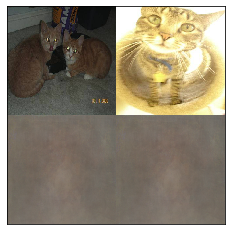

Epoch 2/15
45/45 [==============================] - 26s 576ms/step - loss: 0.3271 - val_loss: 0.3465
Epoch 3/15
45/45 [==============================] - 28s 616ms/step - loss: 0.3235 - val_loss: 0.3470
Epoch 4/15
45/45 [==============================] - 28s 623ms/step - loss: 0.3221 - val_loss: 0.3464
Epoch 5/15
30/45 [===================>..........] - ETA: 10s - loss: 0.3288

KeyboardInterrupt: ignored

In [0]:

def generator():
  while True:
    X,Y = next(train_gen)
    yield [X, Y, Y], X

def generator_test():
  while True:
    X,Y = next(test_gen)
    yield [X, Y, Y], X    
    
# Запуск обучения 
x_train, y_train_cat = next(train_gen)

# cvae.fit([x_train, y_train_cat, y_train_cat], x_train, shuffle=True, epochs=10,
cvae.fit_generator(generator(), shuffle=True, epochs=15,
         steps_per_epoch = train_gen.samples // batch_size,
         validation_data=(generator_test()),
         nb_val_samples=test_gen.samples // batch_size,
         callbacks=[pltfig], # tb],
         verbose=1)

In [0]:
#X,Y = next(test_gen)
num_classes

2

In [0]:
import numpy as np
import matplotlib.pyplot as plt

digit_size = 224
def plot_digits(*args, invert_colors=False):
    args = [x.squeeze() for x in args]
    n = min([x.shape[0] for x in args])
    figure = np.zeros((digit_size * len(args), digit_size * n, 3))

    for i in range(n):
        for j in range(len(args)):
            figure[j * digit_size: (j + 1) * digit_size,
                   i * digit_size: (i + 1) * digit_size] = args[j][i].squeeze()

    if invert_colors:
        figure = 1-figure

    plt.figure(figsize=(2*n, 2*len(args)))
    plt.imshow(figure)#, cmap='Greys_r')
    plt.grid(False)
    ax = plt.gca()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.show()


#n = 15 # Картинка с 15x15 цифр

def style_transfer(model, X, lbl_in, lbl_out):
    rows = X.shape[0]
    if isinstance(lbl_in, int):
        lbl = lbl_in
        lbl_in = np.zeros((rows, 2))
        lbl_in[:, lbl] = 1
    if isinstance(lbl_out, int):
        lbl = lbl_out
        lbl_out = np.zeros((rows, 2))
        lbl_out[:, lbl] = 1
    #print(lbl_in)
    #print(lbl_out)
    return model.predict([X, lbl_in, lbl_out])
  


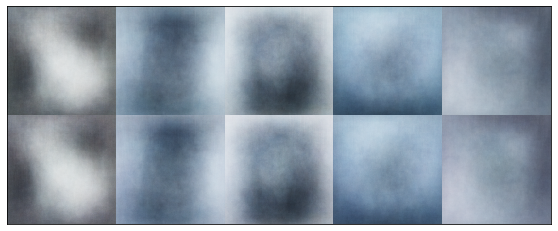

In [0]:
n = 2
lbl = 1
generated = []
X, Y = next(test_gen)
prot = X[:5]



for i in range(num_classes):
    generated.append(style_transfer(models["style_t"], prot, lbl, i))

#generated[lbl] = prot
plot_digits(*generated, invert_colors=True)

In [0]:
#pr = style_transfer(models["style_t"], X[0], 0, 0)
pr = models["style_t"].predict([np.array([X[0]]), np.array([[1,0]]), np.array([[1,0]])])
plt.imshow(pr[0])

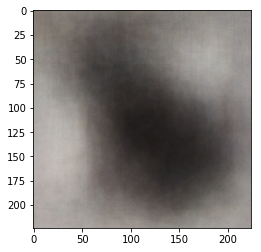

In [0]:
plt.imshow(pr[0])